# Digital Musicology Project - Chord-based Characterization of Choruses and Verses in Pop and Rock Songs

# Research Question

# Presentation of the dataset

The dataset has been created by [1] and corresponds to a random sample of 890 Billboard chart slots presented at ISMIR 2011 and MIREX 2012. Due to the nature of the sampling algorithm, there are some duplicates and this results in only 585 distinct songs. 

This dataset is publicly available at https://ddmal.music.mcgill.ca/research/The_McGill_Billboard_Project_(Chord_Analysis_Dataset)/ and can be downloaded in various formats. Different features are given by the authors. In this project we will mostly rely on chords annotations. 

The main dataset comprehends chords, structure, instrumentation, and timing, given in a txt format. The annotation for each song begins with a header containing the title of the song, the name of the artist, the metre and the tonic pitch class of the opening key. In the main body, each line consists of a single phrase and begins with its timestamp, followed by the chords. This requires us to design a specific parser, as will be discussed in the next section.

An additional file gives more metadata informations such as the dates of the songs.

[1]: John Ashley Burgoyne, Jonathan Wild, and Ichiro Fujinaga, ‘An Expert Ground Truth Set for Audio Chord Recognition and Music Analysis’, in Proceedings of the 12th International Society for Music Information Retrieval Conference, ed. Anssi Klapuri and Colby Leider (Miami, FL, 2011), pp. 633–38

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='white')
import plotly.express as px
import seaborn as sns
import researchpy as rp
from collections import Counter
import scipy

### Metadata informations

In [4]:
metadata_df = pd.read_csv("data/billboard-2.0-index.csv")
metadata_df.head(5)

id  chart_date  target_rank  actual_rank                title  \
0   1  1987-07-11           82          NaN                  NaN   
1   2  1973-08-04           14          NaN                  NaN   
2   3  1961-07-03           56         57.0         I Don't Mind   
3   4  1971-08-07           32         31.0  You've Got A Friend   
4   5  1976-07-10           51          NaN                  NaN   

                         artist  peak_rank  weeks_on_chart  
0                           NaN        NaN             NaN  
1                           NaN        NaN             NaN  
2                   James Brown       47.0             8.0  
3  Roberta Flack,Donny Hathaway       29.0            12.0  
4                           NaN        NaN             NaN

In [5]:
print('The songs range from %s to %s.' %(metadata_df.chart_date.min(), metadata_df.chart_date.max()))

The songs range from 1958-08-18 to 1991-11-16.


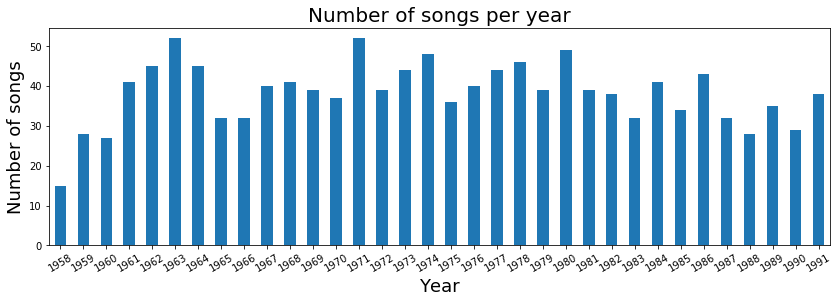

In [6]:
plt.figure(figsize = (14,4))
metadata_df.chart_date.map(lambda y:pd.to_datetime(y).year).value_counts(sort=False).plot(kind='bar')
plt.title("Number of songs per year", fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Number of songs", fontsize = 18)
plt.xticks(rotation = 30)
plt.show()

We can see that our corpus is pretty well distributed over the considered period.

# Preprocessing of the songs

## Parser for the songs

In [7]:
SONG_ID, LINE_NUMBER, MEASURE_NUMBER, CHORD_NUMBER, SEQUENCE_NUMBER, \
CHORD, INSTRUMENT, TYPE, TIME, STRUCTURE, DURATION, REPETITION, ELID = \
"song_id","line_id", "measure_id", "chord_id", "sequence_id",\
"chord", "instrument", "section_type", "time", "section_structure", "duration", "repetition", "elided"

#This is dependant of "metre" in the txt files.
METRE = "metre"

#Create a new dictionary from two other
def immutable_merge(dic1, dic2):
    result = dic1.copy()
    result.update(dic2)
    return result

#Create a row of the futur df as a dictionary
def create_row(persistent_attributes, line_attributes,
               measure_number = None, chord_number = None, chord = None, duration = None):
    result = immutable_merge(persistent_attributes, line_attributes)
    
    if not (measure_number is None and measure_number is None and chord_number is None and duration is None):
        result[MEASURE_NUMBER] = measure_number
        result[CHORD_NUMBER] = chord_number
        result[CHORD] = chord
        result[DURATION] = duration
    
    return result

#Generate the attributes of a given line and update the sequence counter
def process_line_metadata(header, line_counter, old_line_attributes, sequence_counter, suffix = ""):
    
    result = {}
    
    #Suffix (main instrument, elid, repetition)
    old_instrument = str(old_line_attributes.get(INSTRUMENT))
    
    for suffix in suffix.split(", "):
        
        suffix = suffix.strip()
        
        #Repetition
        if re.match("^x\d+$",suffix):
            result[REPETITION] = int(suffix[1])
        
        #Elid
        elif suffix == "->":
            result[ELID] = True

        #Instrument
        else:
            ##New instrument
            if len(suffix) > 0 and suffix != "\n":
                result[INSTRUMENT] = suffix.strip("\n").strip(",").strip()

            ##Main instrument continued (experimental)
            elif not old_instrument.endswith(")") and old_instrument.lower() not in ["nan","none"] \
            and len(old_instrument)>0:
                result[INSTRUMENT] = old_instrument.strip("(")

        
    #Line number
    result[LINE_NUMBER] = line_counter

    
    #Header    
    header_items = header.split()
        
    result[TIME] = header_items[0]
    
    #Case where a section is continued
    if len(header_items) == 1:
        result[TYPE] = old_line_attributes.get(TYPE)
        result[STRUCTURE] = old_line_attributes.get(STRUCTURE)
        result[SEQUENCE_NUMBER] = old_line_attributes.get(SEQUENCE_NUMBER)
    
    #Case where a section has no structure (silence, end, fadeout)
    elif len(header_items) == 2:
        
        #Z is a structure, not a type.
        if header_items[1].strip().strip(",") == "Z":
            result[STRUCTURE] = header_items[1].strip().strip(",")
        else:
            result[TYPE] = header_items[1].strip().strip(",")
            
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    #Case where a section begins.
    elif len(header_items) == 3:
        result[STRUCTURE] = header_items[1].strip().strip(",")
        result[TYPE] = header_items[2].strip().strip(",")
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    return sequence_counter, result

In [8]:
def parse_song_to_dict(song_id, path):
    
    rows = []
    persistent_attributes = {}
    
    persistent_attributes[SONG_ID] = song_id
    
    with open(path,"r") as file:
        line = file.readline()
        
        line_counter = 0
        measure_counter = 0
        chord_counter = 0
        sequence_counter = 0
        line_attributes = {}
        old_chord = None
 

        while line:
        
            if line != "\n":

                #Attribute lines
                if line.startswith("#"):
                    attribute, value = line.strip("#").split(":",1)
                    persistent_attributes[attribute.strip(" ")] = value.strip(" ").strip("\n")

                else:
                    line_items = line.split("|")

                    #Special lines
                    if len(line_items) <= 1:
                        sequence_counter, line_attributes = \
                        process_line_metadata(line, line_counter, line_attributes, sequence_counter)
                        row = create_row(persistent_attributes, line_attributes)
                        rows.append(row)

                    #Standard lines    
                    else:                    
                        header = line_items[0]
                        suffix = line_items[-1]
                        measures = line_items[1:-1]

                        sequence_counter, line_attributes = \
                        process_line_metadata(header, line_counter, line_attributes, sequence_counter, suffix)  

                        for measure in measures:
                            
                            chords = measure.split()
                            
                            #Special metric (experimental)
                            old_metre = persistent_attributes.get(METRE)
                            if re.match("^\(\d/\d\)$", chords[0]):
                                persistent_attributes[METRE] = str(chords[0][1]) + "/" + str(chords[0][3])
                                chords = chords[1:]
                            
                            if len(chords) == 1:
                                duration = "measure"
                            elif len(chords) == 2 and persistent_attributes[METRE] in ["4/4","12/8"]:
                                duration = "half-measure"
                            else:
                                duration = "beat"
                            
                            for chord in chords:
                                
                                if chord == ".":
                                    chord = old_chord
                                
                                row = create_row(persistent_attributes, line_attributes,
                                                 measure_counter, chord_counter, chord, duration)
                                rows.append(row)
                                old_chord = chord
                                chord_counter += 1

                            measure_counter += 1
                            persistent_attributes[METRE] = old_metre
            
            #Finally
            line_counter += 1
            line = file.readline()
    
    
    return rows

In [9]:
def create_whole_collection_df():
    
    path = "data/McGill-Billboard/"
    file_name = "/salami_chords.txt"
    UPPER_BOUND = 1300
    
    whole_collection = []
    
    i = 0
    while i <= UPPER_BOUND:
        full_path = path + "0"*(4-len(str(i)))+ str(i) + file_name
        
        if os.path.exists(full_path):
            whole_collection += parse_song_to_dict(i, full_path)
        
        i += 1
        
    whole_collection_df = pd.DataFrame(whole_collection)
    
    return whole_collection_df.astype({SEQUENCE_NUMBER: 'Int64', MEASURE_NUMBER: 'Int64', CHORD_NUMBER: 'Int64', \
                                      REPETITION: 'Int64'})

In [10]:
collection_df = create_whole_collection_df()

## Parser for the chords

We also define a parser to better handle the chords. This is based on the notation defined in [Symbolic Representation of Musical Chords: a Proposed Syntax for Text Annotations](http://ismir2005.ismir.net/proceedings/1080.pdf) by C. Harte, M. Sandler, S. Abdallah and E. Gomez. Some notations are also added by the authors of the dataset and therefore included to handle all the 978 unique chords in the dataset. 

In [11]:
print('There are %d unique chords in the dataset.' %len(collection_df.chord.unique()))

There are 978 unique chords in the dataset.


In [12]:
#Split a string and changes the target field depending on which side of the split to take
#side : 0 for left and 1 for right
def split_add(c,dic,split_char,target,side):
    temp=str.split(str(c),split_char)

    dic[target]=temp[side]
    return dic, temp[1-side]


def chord_to_tab(c):
    c=str(c)
    chord={"root":"", "shorthand" : "", "degree_list":[], "bass":"", "N" :False}
    rest=""
    
    if(c=="N"):
        chord["N"] = True
        return chord
    
    c=c.replace(")","")
    
    if('/' in c):
        chord, rest=split_add(c,dic=chord,split_char="/",target="bass",side=1)
    else :
        rest=c
    if(':' in rest):
        chord, rest=split_add(rest,dic=chord,split_char=":",target="root",side=0)
    if('(' in rest):
        chord, rest=split_add(rest,dic=chord,split_char="(",target="degree_list",side=1)
    if(rest != ""):
        chord["shorthand"]=rest
    
    return chord

    

In [13]:
collection_df['chord_dic'] = collection_df.chord.map(lambda y : chord_to_tab(y))
for key in ['root', 'shorthand', 'degree_list', 'bass', 'N']:
    collection_df[key] = collection_df.chord_dic.map(lambda y: y[key])
collection_df.drop(columns = 'chord_dic', inplace = True)
#df = collection_df[['song_id', 'title', 'artist', 'tonic', 'section_type', 'sequence_id', 'chord', 'root', 'shorthand', 'degree_list', 'bass', 'N']]

### Creation of new columns of relative-to-tonic roots

In [14]:
TPC_DIC = {"Cb":11,"C":0,"C#":1,"Db":1,"D":2,"D#":3,"Eb":3,"E":4,"E#":5,"Fb":4,"F":5,"F#":6,
           "Gb":6,"G":7,"G#":8,"Ab":8,"A":9,"A#":10,"Bb":10,"B":11,"B#":0}

In [15]:
collection_df["root_tpc"] = collection_df.root.apply(lambda r : TPC_DIC.get(r))
collection_df = collection_df.astype({"root_tpc":"Int64"})

In [16]:
collection_df["relative_root_tpc"] =\
collection_df.apply(lambda row: (row["root_tpc"] - TPC_DIC.get(row["tonic"]))%12,axis = 1)

In [17]:
collection_df = collection_df.fillna({REPETITION:1})

### Creation of the dataframe with only songs that have both a verse and a chorus

In [18]:
valid_songs = collection_df[[SONG_ID,TYPE]].drop_duplicates().groupby(SONG_ID)[TYPE].apply(list)\
.apply(lambda l: "chorus" in l and "verse" in l)

In [19]:
d_collection_df = collection_df.merge(valid_songs.reset_index().rename(columns = {TYPE:"valid"}),on = SONG_ID)
d_collection_df = d_collection_df[d_collection_df.valid].drop(columns = 'valid')

In [20]:
print('The corpus has %d songs.' %len(d_collection_df.song_id.unique()))

The corpus has 712 songs.


### Dropping duplicates songs

In [21]:
ids_to_keep = d_collection_df[["song_id","title"]].drop_duplicates("title")["song_id"].values
d_collection_df = d_collection_df[d_collection_df.song_id.isin(ids_to_keep)]

In [22]:
print('The final corpus has %d songs.' %len(d_collection_df.song_id.unique()))

The final corpus has 585 songs.


## Creation of a one-row-per-beat dataframe

Duration of measure: all metre in the corpus are regular except song 700 (5/8 = 3 + 2). This was counted as two beats.

In [23]:
def weight_row(metre, duration, repetition):
    """
    Indicate to how many beats in total a chord described on a dataframe's row correspond.
    Careful ! The chords are non-successive in case of repetition
    """
    num, denom = metre.split("/")
    
    if metre == "5/8": #Specific to this dataset
        beat_per_measure = 2
    else:
        beat_per_measure = int(num)/(1 if int(denom) == 4 else 3)
    
    if duration == "measure":
        return beat_per_measure*(repetition)
    
    elif duration == "half-measure":
        return beat_per_measure/2*(repetition)
    
    elif duration == "beat":
        return repetition
    
    else:
        return 0

def successive_repetition_row(metre,duration):
    """
    Indicate on how many successive beats a chord is present
    """
    return weight_row(metre,duration,repetition=1)

In [24]:
# Creation of one-row-per-bit dataframe
N_SUCC_BEATS = "n_succ_beats"

d_collection_df[N_SUCC_BEATS] = d_collection_df.apply(\
    lambda row: successive_repetition_row(row[METRE], row[DURATION]),axis=1)
d_collection_df = d_collection_df.astype({N_SUCC_BEATS:"Int64"})

In [25]:
from tqdm import tqdm

def create_beats_df(d_collection_df):
    beats_dics = []
    repetition_flag = False
    repeted_dics = []
    repetition_line = np.PINF
    repetition_song = np.PINF
    for i in tqdm(d_collection_df.reset_index().index):

        if repetition_flag == True and\
(repetition_line != d_collection_df.iloc[i][LINE_NUMBER] or repetition_song != d_collection_df.iloc[i][SONG_ID]):

            for r in range(repetition_n):
                beats_dics += repeted_dics

            repetition_flag = False
            repeted_dics = []
            repetition_line = np.PINF
            repetition_song = np.PINF
        
        
        if d_collection_df.iloc[i][REPETITION] == 1 :

            for b in range(d_collection_df.iloc[i][N_SUCC_BEATS]):
                beats_dics.append(d_collection_df.iloc[i].to_dict())

        else:

            repetition_flag = True
            repetition_line = d_collection_df.iloc[i][LINE_NUMBER]
            repetition_song = d_collection_df.iloc[i][SONG_ID]
            repetition_n = d_collection_df.iloc[i][REPETITION]

            for b in range(d_collection_df.iloc[i][N_SUCC_BEATS]):
                repeted_dics.append(d_collection_df.iloc[i].to_dict())

    beats_collection_df = pd.DataFrame(beats_dics)
    
    return beats_collection_df

In [26]:
beats_collection_df = create_beats_df(d_collection_df)
beats_collection_df = beats_collection_df.drop(N_SUCC_BEATS,axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 87919/87919 [01:06<00:00, 1317.15it/s]


Let's add the relative chord (using the relative root tpc previously obtained, the shorthand and the bass note).

In [27]:
beats_collection_df['relative_chord'] = beats_collection_df['relative_root_tpc'].astype(str) + beats_collection_df['shorthand'] + beats_collection_df['bass']

### Aggregated features

We will create new aggregated features, where we only consider the relative-to-the-tonic root of the chord and whether it's a major or a minor chord (or another chord quality).

In [28]:
def LabelMinMajChord(chord):
    label = 'other'
    if 'min' in chord: #This will label minmaj7 as a minor chord
        label = 'min' 
    elif 'maj' in chord:
        label = 'maj'
    return label

In [29]:
beats_collection_df['agg_chord_label'] = beats_collection_df['relative_root_tpc'].astype(str) + beats_collection_df['shorthand'].map(lambda x: LabelMinMajChord(x))

In [30]:
beats_collection_df[['song_id', 'title', 'artist', 'metre', 'tonic', 'section_type', 'sequence_id', 
                     'chord', 'root', 'shorthand', 'degree_list', 'bass', 'N', 'root_tpc',
                     'relative_root_tpc', 'relative_chord', 'agg_chord_label']].sample(5)

song_id                        title            artist metre tonic  \
45311       227         Promises In The Dark       Pat Benatar   4/4     F   
158890      823                  Lovely Day       Bill Withers   4/4     E   
197376     1041  It Keeps Right On A-Hurtin'  Johnny Tillotson   4/4     A   
19457        99         A Trick Of The Night        Bananarama   4/4     C   
123837      620      Twisting the Night Away       Rod Stewart   4/4     D   

       section_type  sequence_id    chord root shorthand degree_list bass  \
45311         verse          2.0   D:min7    D      min7          []        
158890       chorus         10.0  C#:min7   C#      min7          []        
197376        verse          4.0      E:7    E         7          []        
19457     pre-verse          2.0    C:min    C       min          []        
123837          NaN          NaN    B:min    B       min          []        

            N  root_tpc  relative_root_tpc relative_chord agg_chord_label  
45311   False       2.0                9.0        9.0min7          9.0min  
158890  False       1.0                9.0        9.0min7          9.0min  
197376  False       4.0                7.0           7.07        7.0other  
19457   False       0.0                0.0         0.0min          0.0min  
123837  False      11.0                9.0         9.0min          9.0min

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5;">
    <strong>Conclusion:</strong> the final dataframe beats_collection_df has the following properties:
    <ul>
        <li>each row corresponds to a beat and thus to a chord played</li>
        <li>only songs with both a verse and a chorus are kept</li>
        <li>for each chord we have the root (absolute and relative-to-the-tonic), the quality and the bass note</li>
        <li>for each chord we add the corresponding aggregated feature</li>
    </ul>
</div>

## Squeeze functions

As a last processing step, we define a function to obtain a dataframe with all the chords of a song squeezed in its various sections (intro, first verse, chorus, second verse...). This will be helpful later in our analysis.

In [31]:
#The squeeze function returns a dataframe with all the chords of a song squeezed in a row dependent on a subgroup
# of the section type. Default is "none" and will not filter any type of songs.
#try subgroup="chorus" or subgroup="verse"

def compress(s) :
    return s.dropna().to_list()

def squeeze(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
    df_local = df_local.groupby(["song_id","title"])\
                        [["chord", "root", "shorthand", "bass", "relative_root_tpc", "relative_chord", "agg_chord_label"]]\
                        .agg(compress).reset_index()
    
    return df_local

In [32]:
squeeze(beats_collection_df).head()

song_id                title  \
0        4  You've got a Friend   
1       10      An Innocent Man   
2       12    Lookin' for Love    
3       16              She Bop   
4       18      Kiss On My List   

                                               chord  \
0  [Ab:maj, Ab:maj, Ab:maj, Ab:maj, Db:maj/5, Db:...   
1  [C:maj, C:maj, C:maj, C:maj, C:maj, C:maj, C:m...   
2  [E:min, E:min, E:min, E:min, F#:min, F#:min, F...   
3  [A:min, A:min, A:min, A:min, A:min, A:min, A:m...   
4  [C:maj, C:maj, G:maj/11, G:maj/11, A:min/b3, A...   

                                                root  \
0  [Ab, Ab, Ab, Ab, Db, Db, Db, Db, Ab, Ab, Ab, A...   
1  [C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...   
2  [E, E, E, E, F#, F#, F#, F#, G, G, G, G, A, A,...   
3  [A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...   
4  [C, C, G, G, A, A, G, G, C, C, C, C, C, C, C, ...   

                                           shorthand  \
0  [maj, maj, maj, maj, maj, maj, maj, maj, maj, ...   
1  [maj, maj, maj, maj, maj, maj, maj, maj, maj, ...   
2  [min, min, min, min, min, min, min, min, maj, ...   
3  [min, min, min, min, min, min, min, min, min, ...   
4  [maj, maj, maj, maj, min, min, maj, maj, min7,...   

                                                bass  \
0  [, , , , 5, 5, 5, 5, , , , , , , , , , , , , 5...   
1  [, , , , , , , , , , , , , , , , , , , , , , ,...   
2  [, , , , , , , , , , , , , , , , , , , , , , ,...   
3  [, , , , , , , , , , , , , , , , , , , , , , ,...   
4  [, , 11, 11, b3, b3, 11, 11, , , , , , , , , ,...   

                                   relative_root_tpc  \
0  [0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 7.0, 7.0, 9.0, 9.0, 7.0, 7.0, 0.0, ...   

                                      relative_chord  \
0  [0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj5, 5.0m...   
1  [0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0ma...   
2  [2.0min, 2.0min, 2.0min, 2.0min, 4.0min, 4.0mi...   
3  [0.0min, 0.0min, 0.0min, 0.0min, 0.0min, 0.0mi...   
4  [0.0maj, 0.0maj, 7.0maj11, 7.0maj11, 9.0minb3,...   

                                     agg_chord_label  
0  [0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj, 5.0ma...  
1  [0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0ma...  
2  [2.0min, 2.0min, 2.0min, 2.0min, 4.0min, 4.0mi...  
3  [0.0min, 0.0min, 0.0min, 0.0min, 0.0min, 0.0mi...  
4  [0.0maj, 0.0maj, 7.0maj, 7.0maj, 9.0min, 9.0mi...

In [33]:
#squeeze section allows you to squeeze the sections of songs
def squeeze_section(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
    
    df_local = df_local.groupby(["song_id","title","sequence_id","section_type"])\
                        [["chord", "root", "shorthand", "bass", "relative_root_tpc", "relative_chord", "agg_chord_label"]]\
                        .agg(compress).reset_index()
    df_local['sequence_id'] = df_local['song_id'].astype(str) + ":" + df_local['sequence_id'].astype(int).astype(str)
    
    return df_local

In [34]:
squeeze_section(beats_collection_df).head()

song_id                title sequence_id section_type  \
0        4  You've got a Friend         4:1        intro   
1        4  You've got a Friend         4:2        verse   
2        4  You've got a Friend         4:3   pre-chorus   
3        4  You've got a Friend         4:4       chorus   
4        4  You've got a Friend         4:5       bridge   

                                               chord  \
0  [Ab:maj, Ab:maj, Ab:maj, Ab:maj, Db:maj/5, Db:...   
1  [F:min, F:min, F:min, F:min, C:7/5, C:7/5, C:7...   
2  [G:hdim7, G:hdim7, G:hdim7, G:hdim7, C:7, C:7,...   
3  [Ab:maj, Ab:maj, Ab:maj, Ab:maj, Ab:7, Ab:7, A...   
4  [Gb:maj(9), Gb:maj(9), Gb:maj(9), Gb:maj(9), D...   

                                                root  \
0  [Ab, Ab, Ab, Ab, Db, Db, Db, Db, Ab, Ab, Ab, A...   
1  [F, F, F, F, C, C, C, C, F, F, C, C, F, C, F, ...   
2  [G, G, G, G, C, C, C, C, F, F, C, C, F, C, F, ...   
3  [Ab, Ab, Ab, Ab, Ab, Ab, Ab, Ab, Db, Db, Db, D...   
4  [Gb, Gb, Gb, Gb, Db, Db, Db, Db, Ab, Ab, Ab, A...   

                                           shorthand  \
0  [maj, maj, maj, maj, maj, maj, maj, maj, maj, ...   
1  [min, min, min, min, 7, 7, 7, 7, min, min, 7, ...   
2  [hdim7, hdim7, hdim7, hdim7, 7, 7, 7, 7, min, ...   
3  [maj, maj, maj, maj, 7, 7, 7, 7, maj, maj, maj...   
4  [maj, maj, maj, maj, maj, maj, maj, maj, maj, ...   

                                                bass  \
0               [, , , , 5, 5, 5, 5, , , , , , , , ]   
1  [, , , , 5, 5, , , , , 5, 5, b3, 5, , , , , , ...   
2  [, , , , , , , , , , 5, 5, b3, 5, , , , , , , ...   
3  [, , , , , , , , , , , , , , , , , , , , , , ,...   
4  [, , , , , , , , , , , , , , , , , , , , , , ,...   

                                   relative_root_tpc  \
0  [0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 0.0, ...   
1  [9.0, 9.0, 9.0, 9.0, 4.0, 4.0, 4.0, 4.0, 9.0, ...   
2  [11.0, 11.0, 11.0, 11.0, 4.0, 4.0, 4.0, 4.0, 9...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, ...   
4  [10.0, 10.0, 10.0, 10.0, 5.0, 5.0, 5.0, 5.0, 0...   

                                      relative_chord  \
0  [0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj5, 5.0m...   
1  [9.0min, 9.0min, 9.0min, 9.0min, 4.075, 4.075,...   
2  [11.0hdim7, 11.0hdim7, 11.0hdim7, 11.0hdim7, 4...   
3  [0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.07, 0.07, 0...   
4  [10.0maj, 10.0maj, 10.0maj, 10.0maj, 5.0maj, 5...   

                                     agg_chord_label  
0  [0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj, 5.0ma...  
1  [9.0min, 9.0min, 9.0min, 9.0min, 4.0other, 4.0...  
2  [11.0other, 11.0other, 11.0other, 11.0other, 4...  
3  [0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0other, 0.0...  
4  [10.0maj, 10.0maj, 10.0maj, 10.0maj, 5.0maj, 5...

# Analysis

## Dimensionality Reduction - Is it Possible to Distinguish Verses and Choruses in Low-Dimensional Spaces?

<div style="border:1px solid black; padding:10px 10px; background-color: #FBE7C6;"> 
    In this section, we want to find out if dimensionality reduction methods can be used to distinguish verses and choruses in low-dimensional spaces. To do so, we propose different Bag of Words representations relying on three sets of features (absolute chords, relative-to-the-tonic chords or aggregated features) and two represenations of sequences of chords (concatenated or individual). We test four dimensionality reduction methods: PCA, ICA, t-SNE (both fully initialized or with PCA initialization) and NMF. We show that only with aggregated features some clustering can be observed with PCA, ICA and NMF while t-SNE is still unable to find any meaningful clustering. However the components obtained seem to mostly discriminate between different kind of songs rather than distinguish between choruses and verses.
</div>

### Bag of Words Representation

We will rely on the Bag of Words representation to represent the verse and chorus sequences of the songs in feature space, where different features can be used. Before going in the details of the different features that can be used, we quickly present the general idea of the Bag of Words representation.

It relies on first defining a vocabulary corresponding to all the possible features considered, then count the occurences of each feature in a given sequence and finally normalize the obtained vector by the total number of elements in the sequence. This ensures the following properties for the BoW vector $X$ of size d obtained:

\begin{equation}
0 \le X_i \le 1,  \forall i = 1,...,d
\end{equation}

\begin{equation}
\sum_{i = 1}^d X_i = 1
\end{equation}

Note that d corresponds to the number of features considered.

In our particular case, different features can be considered. The most obvious one is simply taking all the possible chords used in our corpus, either with an absolute root or a relative-to-the-tonic root. 

Another choice to make is how to consider the different occurences of a section type in a song. Consider for instance a song with the following outline: (intro, verse1, chorus1, verse2, chorus2, outro). Two possibles representations can be chosen here:
* concatenated representation: one verse concatenating verse1 and verse2 chords and one chorus concatenating chorus1 and chorus2, and the compute the BoW on the concatenated sequence of chords
* individual representation: directly compute the BoW on each individual section, thus getting two verse BoW and two chorus BoW

A priori both these representations have some drawbacks. Indeed, in the first case the results might be skewed by the overall differences bewteen songs while in the second case they could be skewed by the internal differences between various verses or choruses of a song. Thus we will later compare these two representations and test our dimensionality reduction methods on both.

To compute the BoW representations, we  start by creating the two vocabularies (the list of features used).

In [35]:
vocab_absolute = dict.fromkeys(beats_collection_df.chord.unique(), 0) 
vocab_relative = dict.fromkeys(beats_collection_df.relative_chord.unique(), 0) 

Let's remove the non-chords elements.

In [36]:
for non_chord in ['', '&pause', 'nan', 'nan*']:
    vocab_absolute.pop(non_chord, None)
    vocab_relative.pop(non_chord, None)

In [37]:
print("When considering absolute roots, we have %d features." %len(vocab_absolute))
print("When considering relative roots, we have %d features." %len(vocab_relative))

When considering absolute roots, we have 859 features.
When considering relative roots, we have 444 features.


We can then define some functions to compute the BoW representations.

In [38]:
def createBOW(chord_list, vocab):
    '''
    This function take a list of "words" and return the corresponding Bag of Words, using the provided vocabulary.
    '''
    bow = dict.fromkeys(vocab.keys(), 0)
    for chord in chord_list:
        if chord in bow.keys():
            bow[chord] += 1
    #Normalise the BoW to get a distribution
    total = sum(bow.values())
    if total != 0:
        bow = {chord: count/total for chord, count in bow.items()}
    return bow

In [39]:
def createBOW_df_section(df, section, vocab, chord):
    '''
    This function takes a dataframe containing all the chords of the songs and computes the BoW for each concatenated section 
    of the specified type using the given vocabulary. 
    The parameter "chord" allows to select the type of "words" to be used for the BoW.
    '''
    df_squeezed = squeeze(df, section)
    bow_dict = createBOW(df_squeezed[chord].iloc[0], vocab)
    data = pd.DataFrame(bow_dict, index = [0])
    for i in range(1, len(df_squeezed.song_id.unique())):
        bow_dict = createBOW(df_squeezed[chord].iloc[i], vocab)
        data = data.append(pd.DataFrame(bow_dict, index = [i]))
    data['song_id'] = df_squeezed.song_id.unique()    
    
    return data[["song_id"] + list(vocab.keys())]

In [40]:
def createBOW_df_individual_sequence(df, section, vocab, chord):
    '''
    This function takes a dataframe containing all the chords of the songs and computes the BoW for each individual section 
    of the specified type using the given vocabulary. 
    The parameter "chord" allows to select the type of "words" to be used for the BoW.
    '''
    df_squeezed = squeeze_section(df, section)
    bow_dict = createBOW(df_squeezed[chord].iloc[0], vocab)
    data = pd.DataFrame(bow_dict, index = [0])
    for i in range(1, len(df_squeezed.sequence_id.unique())):
        bow_dict = createBOW(df_squeezed[chord].iloc[i], vocab)
        data = data.append(pd.DataFrame(bow_dict, index = [i]))
    data['sequence_id'] = df_squeezed.sequence_id    
    
    return data[["sequence_id"] + list(vocab.keys())]

First, we create the bow representation of concatenated sections corresponding to the given section, in absolute tpc.

In [41]:
df_bow_verse = createBOW_df_section(df = beats_collection_df, 
                                    vocab = vocab_absolute,
                                    section = "verse",
                                    chord = "chord")
df_bow_chorus = createBOW_df_section(df = beats_collection_df, 
                                     vocab = vocab_absolute,
                                     section = "chorus", 
                                     chord = "chord")

Then the same in relative to the tonic tpc.

In [42]:
df_bow_verse_rel = createBOW_df_section(df = beats_collection_df, 
                                        section = "verse", 
                                        vocab = vocab_relative, 
                                        chord = "relative_chord")
df_bow_chorus_rel = createBOW_df_section(df = beats_collection_df, 
                                         section = "chorus", 
                                         vocab = vocab_relative, 
                                         chord = "relative_chord")

And finally we create the bow representation for individual sections. Here as well we use the relative to the tonic tpc.

In [44]:
df_bow_chorus_rel_seq = createBOW_df_individual_sequence(df = beats_collection_df, 
                                                         section = "chorus", 
                                                         vocab = vocab_relative, 
                                                         chord = "relative_chord")
df_bow_verse_rel_seq = createBOW_df_individual_sequence(df = beats_collection_df, 
                                                        section = "verse", 
                                                        vocab = vocab_relative, 
                                                        chord = "relative_chord")

#### Considerations on whether to consider each section individually or concatenated together by song

Before actually applying our dimensionality reduction methods on the BoW we have just computed, we should test whether the two sequence representation (concatenated or individual) are similar enough or not. To do so, we propose two methods:
* compute the differences between the BoW of a song, averaged over all the individual sections for that song, and the BoW obtained when concatenating all these sections
* compute the cosine distances between the BoW of the individual sections of a song and the BoW obtained when concatenating all the corresponding sections

The [SciPy](https://www.scipy.org/) library is used to streamline our computations.

In [45]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cosine

In [46]:
df_bow_chorus_rel_seq['song_id'] = df_bow_chorus_rel_seq['sequence_id'].map(lambda x: int(x.split(':')[0]))
df_bow_verse_rel_seq['song_id'] = df_bow_verse_rel_seq['sequence_id'].map(lambda x: int(x.split(':')[0]))

In [47]:
def ComputeDifferences_MeanBoWSection_BoWSong(df1, df2, vocab, section):
    '''
    This function computes the differences between the mean BoW of each section of a song taken individually 
    and the BoW of the song when concatening all the sequences of the given section type.
    '''
    diff = (df1.groupby('song_id').mean().reset_index()[vocab.keys()] - df2[vocab.keys()]).mean()
    plt.figure(figsize = (14,4))
    diff.plot(kind = 'hist', bins = 100, fontsize = 14)
    title = 'Distribution of the differences between \n the mean BoW of each section of a song and the BoW of the song (' + section + ')'
    plt.title(title, fontsize = 20)
    plt.xlabel('Difference', fontsize = 18)
    plt.ylabel('Number of songs', fontsize = 18)
    plt.show()
    
    print("Statistics:")
    print(rp.summary_cont(diff))

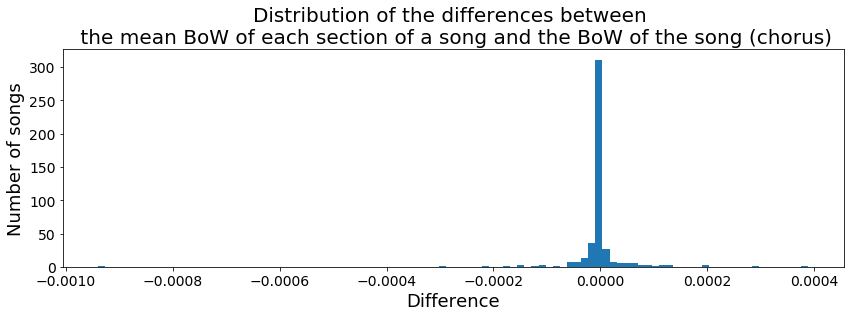

Statistics:


   Variable      N      Mean        SD        SE  95% Conf.  Interval
0       NaN  444.0 -0.000002  0.000061  0.000003  -0.000008  0.000004


In [48]:
ComputeDifferences_MeanBoWSection_BoWSong(df1 = df_bow_chorus_rel_seq, 
                                          df2 = df_bow_chorus_rel, 
                                          vocab = vocab_relative, 
                                          section = "chorus")

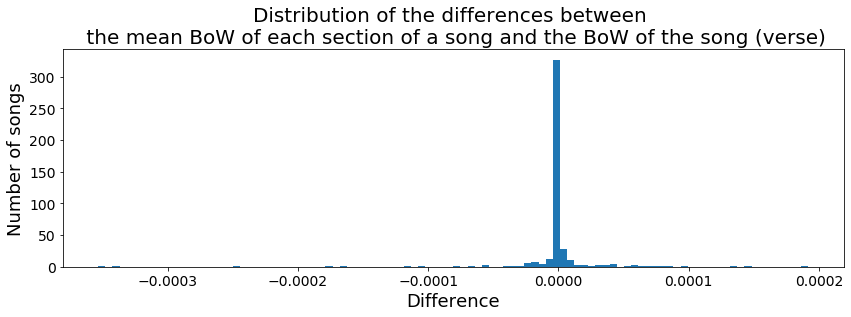

Statistics:


   Variable      N          Mean        SD        SE  95% Conf.  Interval
0       NaN  444.0 -9.625010e-07  0.000036  0.000002  -0.000004  0.000002


In [49]:
ComputeDifferences_MeanBoWSection_BoWSong(df1 = df_bow_verse_rel_seq, 
                                          df2 = df_bow_verse_rel, 
                                          vocab = vocab_relative, 
                                          section = "verse")

With this first method, we can see that the differences are distributed with a clear pick around 0. We also notice that there seem to be some outliers but the absolute differences overall remain extremely small, under 0.001. It is worthwhile noting that the outliers have bigger differences for the choruses, perhaps because there are bigger differences between individual choruses of those songs.

In [50]:
def ComputeCosineDistances_BoWSection_FullBoW(df1, df2, vocab, section):
    '''
    This function computes the cosine distances between the BoW of each section of a song taken individually 
    and the BoW of the song when concatening all the sequences of the given section type.
    '''
    diff = []
    for seq_id in df1.sequence_id.unique():
        diff.append(cosine(df1[df1.sequence_id == seq_id][vocab.keys()].squeeze(),
                           df2[df2.song_id == int(seq_id.split(':')[0])][vocab].squeeze()))
    plt.figure(figsize = (14,4))
    plt.hist(diff, bins = 100)
    title = 'Distribution of the cosine distances between \n the BoW of each section of a song and the full BoW of the song (' + section + ')'
    plt.title(title, fontsize = 20)
    plt.xlabel('Cosine Distance', fontsize = 18)
    plt.ylabel('Number of \n Individual Section / Full Song Pairs', fontsize = 18)
    plt.show()
    
    print("Statistics:")
    print(rp.summary_cont(pd.Series(diff)))

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



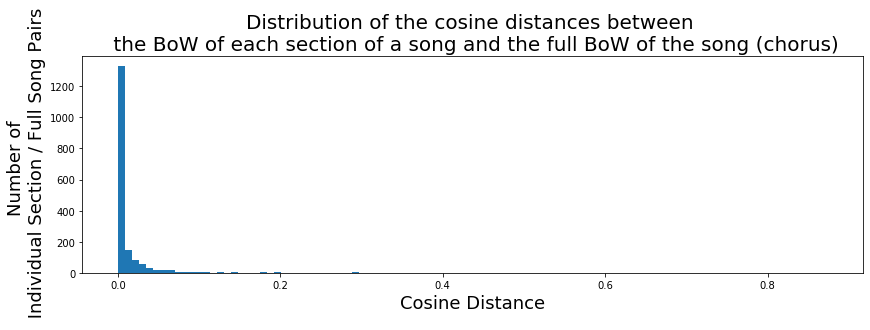

Statistics:


   Variable       N      Mean        SD        SE  95% Conf.  Interval
0       NaN  1887.0  0.028152  0.086602  0.001994   0.024242  0.032062


In [51]:
ComputeCosineDistances_BoWSection_FullBoW(df1 = df_bow_chorus_rel_seq, 
                                          df2 = df_bow_chorus_rel, 
                                          vocab = vocab_relative, 
                                          section = "chorus")

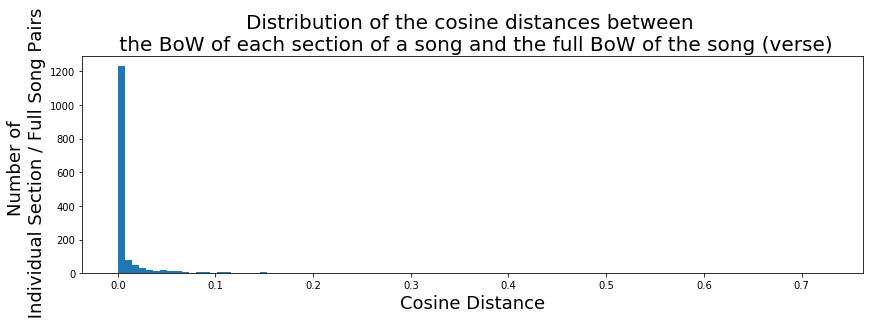

Statistics:


   Variable       N      Mean        SD        SE  95% Conf.  Interval
0       NaN  1586.0  0.019987  0.073937  0.001857   0.016346  0.023629


In [52]:
ComputeCosineDistances_BoWSection_FullBoW(df1 = df_bow_verse_rel_seq, 
                                          df2 = df_bow_verse_rel, 
                                          vocab = vocab_relative, 
                                          section = "verse")

With this second method, the results are very similar, with a distribution clearly peaked at 0. Again the cosine distances are slightly higher for choruses but overall the two representations (concatenated or individual sequences) seem to be very similar.

#### Aggregated features

Finally, since when considering all chords we end up with large feature spaces (over 400-dimension spaces for the relative chords and over 800-dimension spaces for the absolute chords), we try to aggregate them and create a new set of features. To do so, we consider the relative-to-the-tonic root (in tpc) and we classify the quality of the chord as "major", "minor" or "other". Note these features are already obtained for each chord in the preprocessing steps.

In [53]:
def PlotAggregatedFeaturesCount(section):
    '''
    This function plots the occurences of the aggregated features on the whole corpus, on the specified section type.
    '''
    plt.figure(figsize = (14,4))
    beats_collection_df[beats_collection_df.section_type == section]['agg_chord_label'].value_counts().plot(kind = 'bar')
    title = 'Number of chords for the new aggregated features on the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Aggregated feature', fontsize = 18)
    plt.xticks(rotation = 45)
    plt.ylabel('Number of chords', fontsize = 18)
    plt.show()

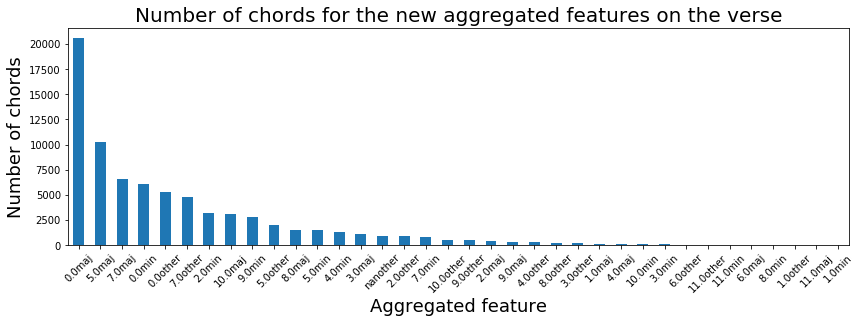

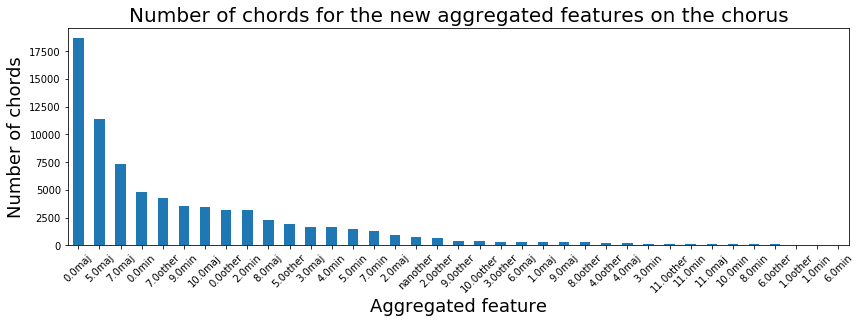

In [54]:
for section in ['verse', 'chorus']:
    PlotAggregatedFeaturesCount(section = section)

As we can see, both on the verses and the choruses, most of the chords are in major, with a main presence of 0maj, 5maj and 7maj, followed by 0min. This of course reflects the importance of the tonic and the dominant in Western music.

We still need to remove the chord starting with nan.

In [55]:
features_agg = beats_collection_df.agg_chord_label.unique()
features_agg = np.delete(features_agg, 13)
features_agg = dict.fromkeys(features_agg, 0)

With this newly created features, we end up with a 36-dimension space (meaning that all combinations of relative root and chord quality are present in our corpus).

In [56]:
print('There are %d aggregated features.' %len(features_agg.keys()))

There are 36 aggregated features.


We can now create the new BoW representations for the verses and the choruses using the new aggregated features, by considering the concatenated representation of sequences (arbitrary choice, since the two representations are very similar).

In [57]:
df_bow_verse_agg = createBOW_df_section(df = beats_collection_df, 
                                        section = 'verse', 
                                        vocab = features_agg, 
                                        chord = 'agg_chord_label')
df_bow_chorus_agg = createBOW_df_section(df = beats_collection_df, 
                                         section = 'chorus', 
                                         vocab = features_agg, 
                                         chord = 'agg_chord_label')

### Dimensionality Reductions Method

Dimensionality reduction is the process of reducing the number of features needed to represent a dataset, thus reducing the dimensionality of the space in which the dataset lies. This can be used either to find features that explain the data better or even to reduce the dimension low-enough so that it can be represented (thus on a 2D or 3D plot).

There are various methods to do so and in this project we rely on four of them: 
* Principal Component Analysis (PCA)
* Independent Component Analysis (ICA)
* t-distributed Stochastic Neighbor Embedding (tSNE)
* Non-Negative Matrix Factorization (NMF)

In this section we will first explain these three methods and present the functions used to train the model and plot the results. Some utilitu functions to better investigate the results are also presented.

We will use the scikit-learn Python library, presented by [Scikit-learn: Machine Learning in Python](http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html), Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

We define a few absolute constants to homogenize the plots for the dimensionality reduction methods. 

In [58]:
ALPHA = 0.2
FIGSIZE = (6,6)
TITLE_FS = 18
AX_LABEL_FS = 16

#### Principal Component Analysis (PCA)

Perhaps the most used dimensionality reduction method, PCA performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. This ensures that the Principal Components obtained best explain the data since they explain most of its variance.

From a mathematical point of view, the transformation from the high-dimensional space to the lower-dimensional space is defined by a set of vectors $\vec{w}_{(k)}$ that map linearly each data sample $\vec{x}_{(i)}$ to a Principal Component $\vec{t}_{(i)}$ given by $t_{k(i)} = \vec{x}_{(i)} \cdot \vec{w}_{(k)}$. The weights $\vec{w}_{(k)}$ are iteratively obtained by maximizing the variance $\sum_{i} (\vec{t}_{(i)})^2 = \sum_{i} (\vec{x}_{(i)} \cdot \vec{w}_{(k)})^2$.

The [scikit-learn implementation of PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) presents in details all the parameters. The important ones here are:
* the number of components n_components (either an integer value specifying the number of Principal Components wanted or a float number specifying the amount of variance that we want to explain)
* the svd_solver used for the Singular Value Decomposition
* the random_state (in this case, the seed used by the random number generator)

In [59]:
from sklearn.decomposition import PCA

In [60]:
def PCA_visualization(df_verse, df_chorus, vocab, n_comps):
    '''
    This function train the PCA model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The number of Principal Components we want is specified.
    Once the model is trained, the PCs are plotted in 2D, coloring the verses in red and the choruses in blue.
    '''
    #Train the pca model
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    pca_model = PCA(n_components = n_comps, svd_solver = "full", random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = pca_model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['PC1'], 
                principalDf[principalDf.label == 0]['PC2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['PC1'], 
                principalDf[principalDf.label == 1]['PC2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    #Title of the plot
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + ', #components: 2)'
    title = 'PCA on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('PC1', fontsize = AX_LABEL_FS)
    plt.ylabel('PC2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()
    
    return pca_model

In [61]:
def PCA_explainedVariance(df_verse, df_chorus, vocab, prop_variance, num_PCs):
    '''
    This function aims at finding the number of PCs to explain a given proportion of variance 
    and also print the explained variance for the first num_PCs components.
    '''
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    pca_model = PCA(n_components = prop_variance,
                    svd_solver = "full", 
                    random_state = 42)
    pca_model.fit(X)
    print('The mininum number of PCs to explain %0.2f%% of the variance is %d.' % (100 * prop_variance, pca_model.n_components_))
    for (pc_i, var_ratio) in enumerate(pca_model.explained_variance_ratio_[:num_PCs]):
        print('The PC%d explains %0.2f%% of the total variance.' % (pc_i + 1, 100 * var_ratio))

In [62]:
def InspectWeightVector(weights, pc, features, n_weights, model_name):
    '''
    This function helps investigate the weights vectors w output by the model (used both for PCA and for ICA).
    It plots in a barplot the top n_weights elements from the sorted weight vector elements, 
    where each weight vector corresponds to a given feature of the data in the high-dimensional space.
    '''
    pc_id = pc - 1
    top_positive_weights = pd.DataFrame(columns = features, data = weights)\
                                                .iloc[pc_id].sort_values(ascending = False)[:n_weights]
    top_negative_weights = pd.DataFrame(columns = features, data = weights)\
                                                .iloc[pc_id].sort_values(ascending = True)[:n_weights].sort_values(ascending = False)
    plt.figure(figsize = (10,3))
    plt.bar(x = range(n_weights), height = top_positive_weights)
    plt.bar(x = range(-n_weights, 0), height = top_negative_weights)
    plt.xticks(range(-n_weights, n_weights), top_negative_weights.index.append(top_positive_weights.index), rotation = 30)
    title = 'Importance of each feature in Comp' + str(pc) + '\n of the ' + model_name + ' model (top ' + str(n_weights) + ')'
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('Feature', fontsize = AX_LABEL_FS)
    plt.ylabel('Importance of the Feature', fontsize = AX_LABEL_FS)
    plt.grid(True, alpha = 0.5)
    plt.show()

#### Independent Component Analysis (ICA)

ICA aims at separating a data set into independent non-Gaussian components. From a mathematical point of view, the goal is to find the weights $W$ such as $\vec{s} = W\vec{x}$ with $\vec{x}$ the observed sample vectors and $\vec{s}$ a vector of maximally independent components, where the independence can be measured in different ways.

The [scikit-learn implementation of ICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html?highlight=ica#sklearn.decomposition.FastICA) uses FastICA, a fast algorithm to implement ICA.

In [63]:
from sklearn.decomposition import FastICA

In [64]:
def FastICA_visualization(df_verse, df_chorus, vocab, n_comps):
    '''
    This function train the ICA model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The number of Independent Components we want is specified.
    Once the model is trained, the ICs are plotted in 2D, coloring the verses in red and the choruses in blue.
    '''
    #Train the FastICA model
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    ica_model = FastICA(n_components = n_comps, whiten = True, random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = ica_model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['IC1', 'IC2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['IC1'], 
                principalDf[principalDf.label == 0]['IC2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['IC1'], 
                principalDf[principalDf.label == 1]['IC2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    #Title of the plot
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + ', #components: 2)'
    title = 'ICA on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('IC1', fontsize = AX_LABEL_FS)
    plt.ylabel('IC2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()
    
    return ica_model

#### t-distributed Stochastic Neighbor Embedding (tSNE)

t-SNE is a nonlinear algorithm that aims at projecting high-dimensional data in a low-dimensional space (tipically 2D or 3D) for visualization. It relies on modeling each high-dimensional object by a low-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. 

From a mathematical point of view, the algorithm comprehends two main steps: first it creates a probability distribution in the high-dimension space in such a way that similar points have a high chance of being picked together while dissimilar points have an extremely low chance of being picked. It then creates a similar distribution on the low-dimension space and it minimizes the Kullback-Leibler (KL) divergence between the two distributions with respect to the location of the points.

Note that, in the low-dimensional space, a heavy-tailed Student t-distribution is used (hence the name of this algorithm) to allow dissimilar objects to be modeled far apart.

In the [scikit-learn implemenation of t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=tsne#sklearn.manifold.TSNE) , perhaps the most important parameter when optimizing t-SNE is the perplexity. It is defined as $k^S$ with S the Shannon entropy of the conditional probability distribution. It is effectively the number of nearest neighbors t-SNE considers when generating the conditional probabilities. This means that the lower the perplexity, the higher the importance of local variations while, with higher perplexities, the global information of the dataset is considered. Of course this is also directly related to the size of the dataset, since the more points there are, the higher the perplexity should be to get a reasonable sample of the local neighborhood.

Following the ideas of [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/), it is clear that the hyperparameters can really affect the results and that both the cluster sizes and the distances between those clusters do not mean anything.

References: 
* [How to Use t-SNE Effectively](http://doi.org/10.23915/distill.00002), Wattenberg, et al., Distill, 2016. http://doi.org/10.23915/distill.00002
* [Visualizing data using t-SNE](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) Maaten, L.v.d. and Hinton, G., 2008. Journal of Machine Learning Research, Vol 9(Nov), pp. 2579—2605.

In [65]:
from sklearn.manifold import TSNE

In [66]:
def TSNE_visualization(df_verse, df_chorus, vocab, perplexity):
    '''
    This function train the tSNE model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The perplexity we want is specified.
    Once the model is trained, the data projected in the lower-dimensional space is plotted in 2D, 
    coloring the verses in red and the choruses in blue.
    '''
    #Train the tSNE model
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    model = TSNE(n_components = 2, verbose = 0, perplexity = perplexity, random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['Comp1', 'Comp2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['Comp1'], 
                principalDf[principalDf.label == 0]['Comp2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['Comp1'], 
                principalDf[principalDf.label == 1]['Comp2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    #Title of the plot
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + ', perp: ' + str(perplexity) + ')'
    title = 'tSNE on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('Comp1', fontsize = AX_LABEL_FS)
    plt.ylabel('Comp2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()

Since t-SNE is quite computationally expensive, it might sometimes be useful to initialize it with PCA, by reducing the dimensions while preserving enough variance in the original dataset and then use t-SNE on the PCA output to further reduce to two- or three-dimension spaces for visualizations.

In [67]:
def TSNE_PCAinit(df_verse, df_chorus, vocab, pca_comps, perplexity):
    '''
    This function train the tSNE model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The perplexity we want is specified.
    However this time the model is initialized with the output of a PCA model with the given number pca_comps of PCs.
    Once the model is trained, the data projected in the lower-dimensional space is plotted in 2D, 
    coloring the verses in red and the choruses in blue.
    '''
    ##Create PCA input
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    pca_model = PCA(n_components = pca_comps, random_state = 42)
    pca_result = pca_model.fit_transform(X)

    ##TSNE initialized with PCA
    tsne_model = TSNE(n_components = 2, verbose = 0, perplexity = perplexity, random_state = 42)
    tsne_pca_results = tsne_model.fit_transform(pca_result)

    principalDf = pd.DataFrame(data = tsne_pca_results[:,:2], columns = ['Comp1', 'Comp2'])
    principalDf['label'] = y

    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['Comp1'], 
                principalDf[principalDf.label == 0]['Comp2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['Comp1'], 
                principalDf[principalDf.label == 1]['Comp2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + \
               ', \n #PCA_components = ' + str(pca_comps) + ', perp: ' + str(perplexity) + ')'
    title = 'TSNE initialized with PCA on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('Comp1', fontsize = AX_LABEL_FS)
    plt.ylabel('Comp2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()

#### Non-Negative Matrix Factorization (NMF)

NMF (or NNMF) is an algorithm where a matrix $V$ is factorized into two matrices $W$ and $H$, with the property that all elements of these three matrices are non-negative. This is of course particularly interesting in our case since BoW representations have, by definition, all non-negative elements.

From a mathematical point of view, the problem is solved numerically by minimizing the error function $||V - WH||_{\beta}$ subject to $W \ge 0$ and $H \ge 0$, where $||\cdot||_{\beta}$ is a beta-divergence loss function (such as the Frobenius norm with $\beta = 2$ or the Kullback-Leibler divergence with $\beta = 1$.

As shown by the authors of ["On the Equivalence of Nonnegative Matrix Factorization and Spectral Clustering"](http://ranger.uta.edu/~chqding/papers/NMF-SDM2005.pdf), NMF also has clustering properties since, by imposing an orthogonality constraint on matrix H such that $HH^T = I$, the minimization is then matematically equivalent to the one of k-means clustering.

The [scikit-learn implementation of NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) proposes two numerical solver: either Coordinate Descent or Multiplicative Update. We will use the first one here, with the Frobenius loss function:

\begin{equation}
d_F(X, Y) = \frac{1}{2} ||X - Y||_F^2 = \frac{1}{2} \sum_{i,j} (X_{ij} - Y_{ij})^2
\end{equation}

Finally, the reconstruction error between the fitted data $WH$ and the original data $V$ can be used to compare runs of the algorithm with different numbers of components to find the optimal number of components.

Reference:
* C. Ding, X. He, H.D. Simon (2005), [On the Equivalence of Nonnegative Matrix Factorization and Spectral Clustering](http://ranger.uta.edu/~chqding/papers/NMF-SDM2005.pdf), Proc. SIAM Int'l Conf. Data Mining, pp. 606-610. May 2005

In [68]:
from sklearn.decomposition import NMF

In [69]:
def NMF_visualization(df_verse, df_chorus, vocab, n_comps):
    '''
    This function train the NMF model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The number of Principal Components we want is specified.
    Once the model is trained, the components are plotted in 2D, coloring the verses in red and the choruses in blue.
    '''
    #Train the pca model
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    nmf_model = NMF(n_components = n_comps, solver = 'cd', beta_loss = 'frobenius', random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = nmf_model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['PC1'], 
                principalDf[principalDf.label == 0]['PC2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['PC1'], 
                principalDf[principalDf.label == 1]['PC2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    #Title of the plot
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + ', #components: 2)'
    title = 'NMF on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('Comp1', fontsize = AX_LABEL_FS)
    plt.ylabel('Comp2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()
    
    print("Reconstruction error: %0.2f" % nmf_model.reconstruction_err_)
    
    return nmf_model

In [70]:
def InspectNMFWeightVectors(weights, vocab, n_comps, n_weights):
    '''
    This function helps investigate the weights vectors w output by the NMF model.
    It plots in a barplot the top n_weights elements from the sorted weight vector elements, 
    where each weight vector corresponds to a given feature of the data in the high-dimensional space.
    '''
    for i in range(1, n_comps + 1):
        top_positive_weights = pd.DataFrame(columns = vocab.keys(), data = weights).iloc[i - 1].sort_values(ascending = False)[:n_weights]
        plt.figure(figsize = (10,3))
        plt.bar(x = range(n_weights), height = top_positive_weights)
        plt.xticks(range(n_weights), top_positive_weights.index, rotation = 30)
        title = 'Importance of each feature in Comp' + str(i) + '\n of the NMF model (top ' + str(n_weights) + ')'
        plt.title(title, fontsize = TITLE_FS)
        plt.xlabel('Feature', fontsize = AX_LABEL_FS)
        plt.ylabel('Importance of the Feature', fontsize = AX_LABEL_FS)
        plt.grid(True, alpha = 0.5)
        plt.show()

In [71]:
def NMF_Optimization_NumberComponents(df_verse, df_chorus, vocab, max_n_comp):
    '''
    This functions helps finding the optimal number of componenents required to minimize the reconstruction error
    between the fitted data and the actual data.
    '''
    reconstruction_err_list = []
    X = np.concatenate((df_bow_verse_agg.loc[:, features_agg.keys()].values, df_bow_chorus_agg.loc[:, features_agg.keys()].values))
    for n_comp in range(2,max_n_comp):
        model = NMF(n_components = n_comp, random_state = 42)
        model.fit(X)
        reconstruction_err_list.append(model.reconstruction_err_)  
        
    plt.figure(figsize = (12,4))
    plt.scatter(x = range(2,50), y = reconstruction_err_list)
    plt.title('Reconstruction Error as a Function of the Number of Components', fontsize = 18)
    plt.xlabel('Number of Components', fontsize = 16)
    plt.ylabel('Reconstruction Error', fontsize = 16)
    plt.show()

### Application of the methods on the various BoW representations

#### BoW with the concatenated sections and the absolute chords

In [72]:
PCA_explainedVariance(df_verse = df_bow_verse,
                      df_chorus = df_bow_chorus,
                      vocab = vocab_absolute, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 85.
The PC1 explains 10.35% of the total variance.
The PC2 explains 9.51% of the total variance.
The PC3 explains 6.49% of the total variance.
The PC4 explains 4.83% of the total variance.
The PC5 explains 3.92% of the total variance.
The PC6 explains 3.58% of the total variance.
The PC7 explains 3.35% of the total variance.
The PC8 explains 2.65% of the total variance.
The PC9 explains 2.60% of the total variance.
The PC10 explains 2.05% of the total variance.


When using concatenated sections and absolute chords, PCA doesn't seem to be a good method since it would still require 85 components to explain 90% of the variance. 

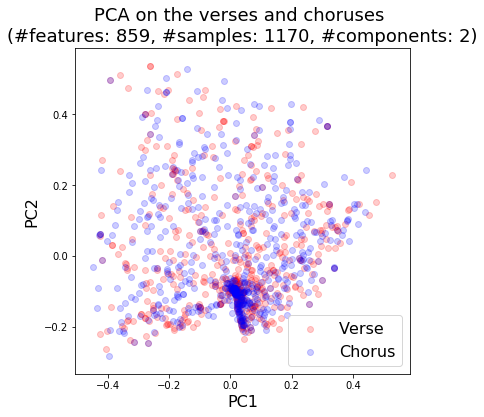

In [73]:
model_pca = PCA_visualization(df_verse = df_bow_verse,
                              df_chorus = df_bow_chorus,
                              vocab = vocab_absolute, 
                              n_comps = 2)

Indeed this results in no clear clusters in 2D and no distinction between choruses and verses. Results have the same problem (no clear cluster or distinction between choruses and verses) when using ICA, t-SNE or NMF so we don't propose all the corresponding plots here.

#### BoW with the concatenated sections and the relative chords

In [74]:
PCA_explainedVariance(df_verse = df_bow_verse_rel,
                      df_chorus = df_bow_chorus_rel,
                      vocab = vocab_relative, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 39.
The PC1 explains 23.85% of the total variance.
The PC2 explains 9.43% of the total variance.
The PC3 explains 8.41% of the total variance.
The PC4 explains 6.31% of the total variance.
The PC5 explains 5.79% of the total variance.
The PC6 explains 4.67% of the total variance.
The PC7 explains 3.58% of the total variance.
The PC8 explains 2.97% of the total variance.
The PC9 explains 2.66% of the total variance.
The PC10 explains 1.94% of the total variance.


This time the number of components required to preserve the variance of the data is lower, at 39, showing how using relative-to-the-tonic chords is indeed better since it isn't affected by the different tonic keys between different songs.

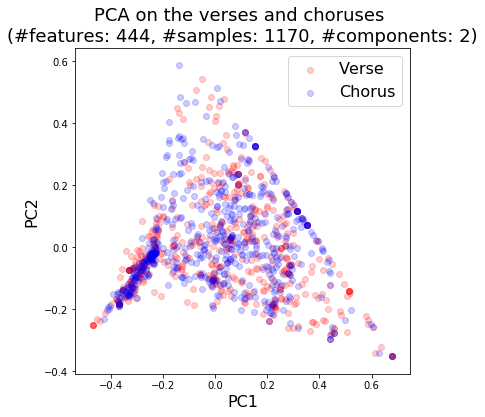

In [75]:
model_pca_rel = PCA_visualization(df_verse = df_bow_verse_rel,
                                  df_chorus = df_bow_chorus_rel,
                                  vocab = vocab_relative, 
                                  n_comps = 2)

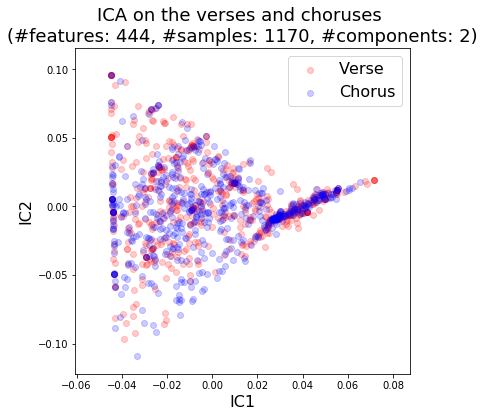

In [76]:
model_ica_rel = FastICA_visualization(df_verse = df_bow_verse_rel,
                                      df_chorus = df_bow_chorus_rel,
                                      vocab = vocab_relative, 
                                      n_comps = 2)

Both PCA and ICA start showing some clustering but it is still quite difficult to have any interpretation. There are no relevant results with t-SNE or NMF.

#### BoW with the individual sections and the relative chords

In [77]:
PCA_explainedVariance(df_verse = df_bow_verse_rel_seq,
                      df_chorus = df_bow_chorus_rel_seq,
                      vocab = vocab_relative, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 40.
The PC1 explains 23.38% of the total variance.
The PC2 explains 9.33% of the total variance.
The PC3 explains 8.19% of the total variance.
The PC4 explains 6.25% of the total variance.
The PC5 explains 5.64% of the total variance.
The PC6 explains 4.51% of the total variance.
The PC7 explains 3.47% of the total variance.
The PC8 explains 2.75% of the total variance.
The PC9 explains 2.59% of the total variance.
The PC10 explains 2.07% of the total variance.


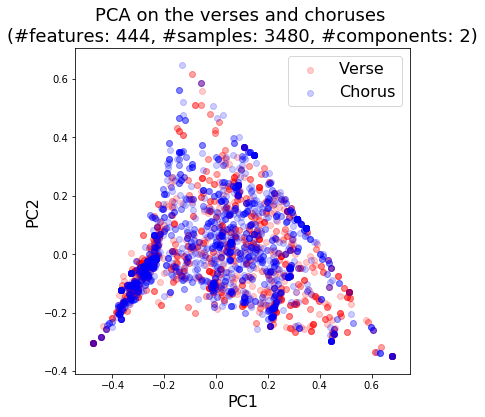

In [78]:
model_pca_rel_seq = PCA_visualization(df_verse = df_bow_verse_rel_seq,
                                      df_chorus = df_bow_chorus_rel_seq,
                                      vocab = vocab_relative, 
                                      n_comps = 2)

As expected from previous results about the comparison between concatenated and individual sequences representations, results are pretty much the same as long as we use relative chords. The same can be said for ICA, t-SNE and NMF. This is why we will rely on the concatenated sequences represention with the aggregated features since considering individual sequences doesn't yield any clear advantage (and would only require more computational power by increasing the number of samples).

#### BoW with the concatenated sections and the aggregated features 

In [79]:
PCA_explainedVariance(df_verse = df_bow_verse_agg,
                      df_chorus = df_bow_chorus_agg,
                      vocab = features_agg, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 11.
The PC1 explains 29.25% of the total variance.
The PC2 explains 14.43% of the total variance.
The PC3 explains 11.43% of the total variance.
The PC4 explains 7.55% of the total variance.
The PC5 explains 7.06% of the total variance.
The PC6 explains 5.51% of the total variance.
The PC7 explains 4.19% of the total variance.
The PC8 explains 3.44% of the total variance.
The PC9 explains 2.97% of the total variance.
The PC10 explains 2.69% of the total variance.


Finally, the required number of components to explain 90% of the variance drops to only 11, with the first explaining nearly 30% of the variance and the first 3 components explaining more than 50% of the variance of the data.

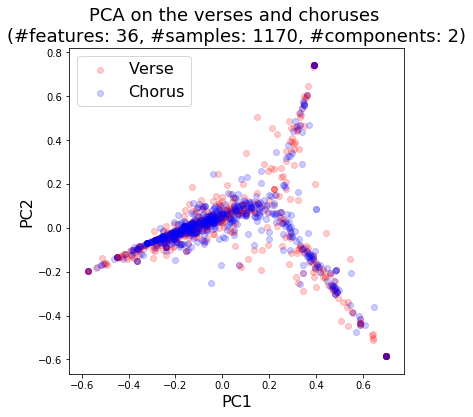

In [80]:
model_pca_agg = PCA_visualization(df_verse = df_bow_verse_agg,
                                  df_chorus = df_bow_chorus_agg,
                                  vocab = features_agg, 
                                  n_comps = 11)

This time, PCA outlines three main regions. Let's also plot PCA in 3D to get more insights on the big cluster on the left hand side of the graph.

In [81]:
from mpl_toolkits.mplot3d import Axes3D

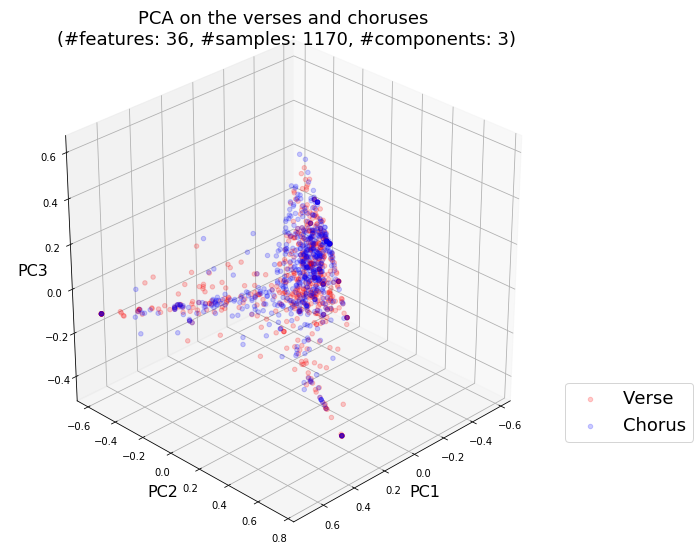

In [82]:
#Train the pca model
X = np.concatenate((df_bow_verse_agg.loc[:, features_agg.keys()].values, df_bow_chorus_agg.loc[:, features_agg.keys()].values))
y = np.concatenate((np.zeros(len(df_bow_verse_agg)), np.ones(len(df_bow_chorus_agg))))
pca_3D = PCA(n_components = 10, svd_solver = "full", random_state = 42)

#Get the principalComponents by fitting the model and transforming the input 
principalComponents = pca_3D.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents[:,:3], columns = ['PC1', 'PC2', 'PC3'])
principalDf['label'] = y

#Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = principalDf[principalDf.label == 0]['PC1'], 
           ys = principalDf[principalDf.label == 0]['PC2'], 
           zs = principalDf[principalDf.label == 0]['PC3'],
           c = 'red',
           alpha = ALPHA,
           label = 'Verse')
ax.scatter(principalDf[principalDf.label == 1]['PC1'], 
           principalDf[principalDf.label == 1]['PC2'], 
           principalDf[principalDf.label == 1]['PC3'],
           c = 'blue',
           alpha = ALPHA,
           label = 'Chorus')
settings = '(#features: ' + str(len(features_agg.keys())) + ', #samples: ' + str(len(X)) + ', #components: 3)'
title = 'PCA on the verses and choruses \n' + settings
plt.title(title, fontsize = TITLE_FS)
ax.set_xlabel('PC1', fontsize = AX_LABEL_FS)
ax.set_ylabel('PC2', fontsize = AX_LABEL_FS)
ax.set_zlabel('PC3', fontsize = AX_LABEL_FS)
ax.view_init(30, 45)
plt.legend(fontsize = 18, loc = (1,0.2))
plt.show()

When plotting in 3D, we see that the big cluster we were seeing in the left half of the previous graph is in fact spread out across PC3. Let's investigate the corresponding weights vectors to better understand what is happening here.

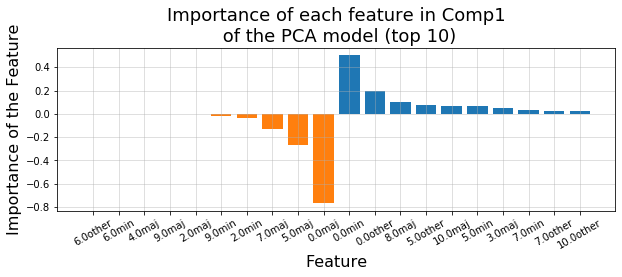

In [83]:
InspectWeightVector(weights = model_pca_agg.components_, 
                        pc = 1, 
                        features = features_agg, 
                        n_weights = 10, 
                        model_name = 'PCA')

The first PC seems to mainly discriminate sequences based on tonic minor (0min) and tonic major (0maj) chords. In particular, the large cluster of points in the left half of the PCA graph corresponds to sequences with a lot of tonic major chords. This goes back to previous results were we highlighted that tonic major were the most common chords in our corpus, resulting here in the biggest cluster of points.

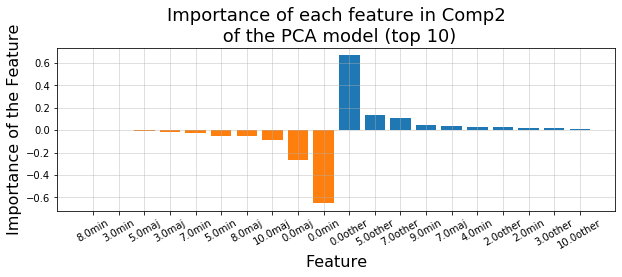

In [84]:
InspectWeightVector(weights = model_pca_agg.components_, 
                        pc = 2, 
                        features = features_agg, 
                        n_weights = 10, 
                        model_name = 'PCA')

The second PC discriminates between tonic major or minor and other tonic chords. It would seem that verses and choruses with tonic that are neither in major or minor are clustered together with positive PC2 values while negative PC2 values correspond to verses and choruses with more tonic major or minor.

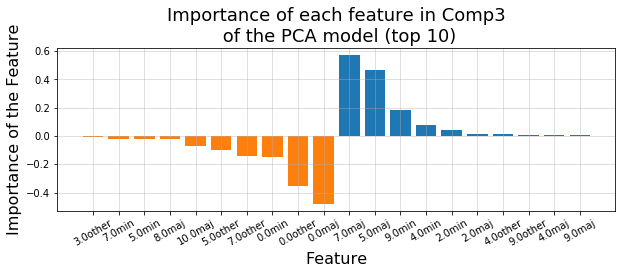

In [85]:
InspectWeightVector(weights = model_pca_agg.components_, 
                        pc = 3, 
                        features = features_agg, 
                        n_weights = 10, 
                        model_name = 'PCA')

Finally, the third PC discriminates among the different qualities of major chords, with positive weights on 7maj and 5maj and a negative weight for 0maj.

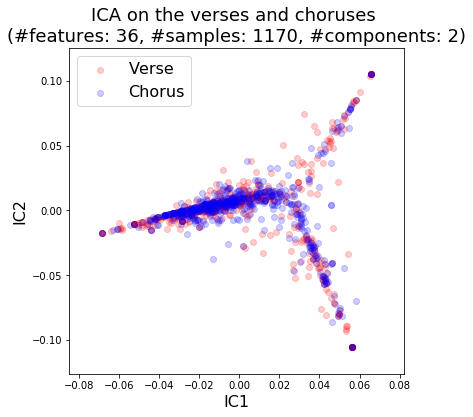

In [86]:
model_ica_agg = FastICA_visualization(df_verse = df_bow_verse_agg,
                                      df_chorus = df_bow_chorus_agg,
                                      vocab = features_agg, 
                                      n_comps = 2)

With 2-components ICA, the results are pretty much the same as with 2D-PCA. We can here as well inspect the corresponding weight vectors.

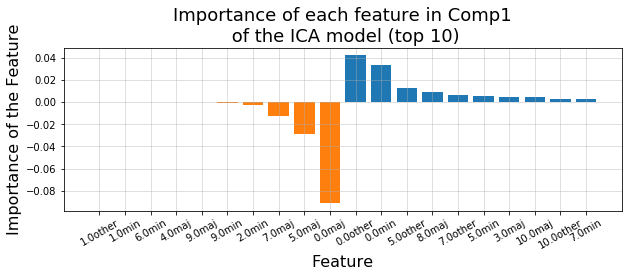

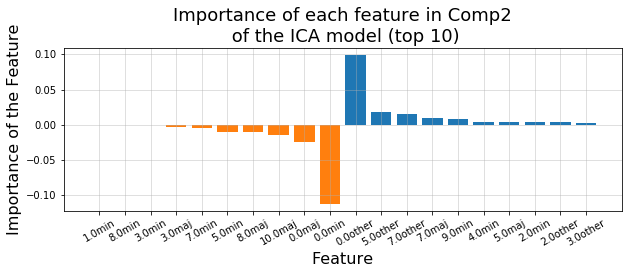

In [87]:
for i in range(1,3):
    InspectWeightVector(weights = model_ica_agg.components_, 
                        pc = i, 
                        features = features_agg, 
                        n_weights = 10, 
                        model_name = 'ICA')

As in PCA, the first component discriminates between tonic major (0maj) and remaining tonic chords (0other and 0min). This time however the weight on 0other is stronger than the one on 0min. For the second component the results are pretty much identical with the ones of PCA, with a discrimination based on the presence on tonic minor (in negative) and other tonic (in positive).

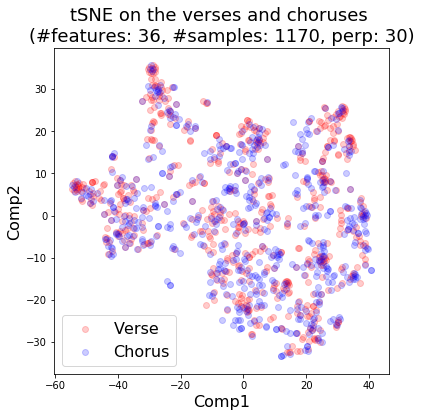

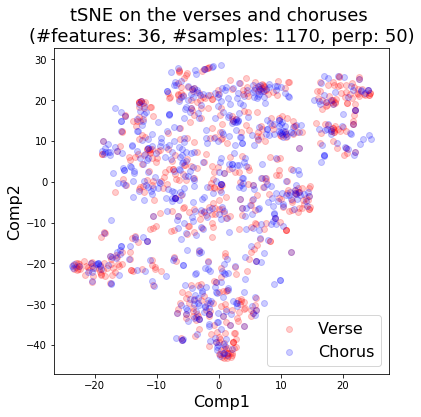

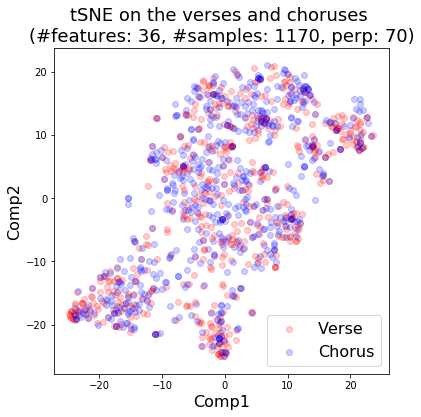

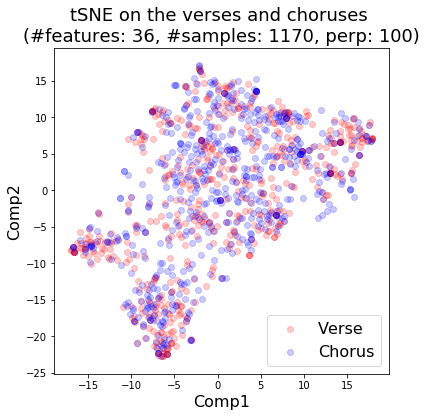

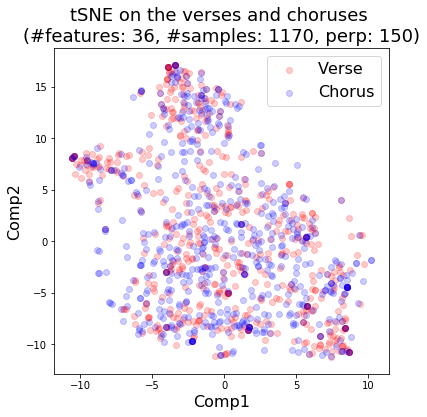

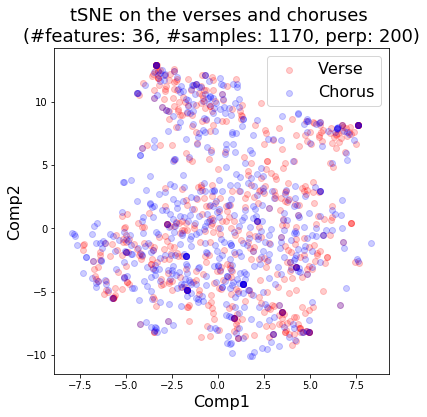

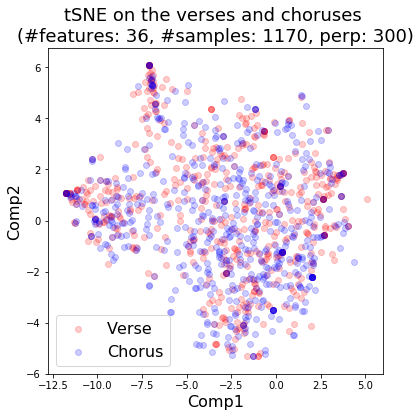

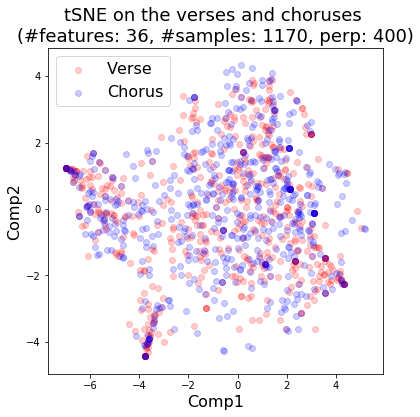

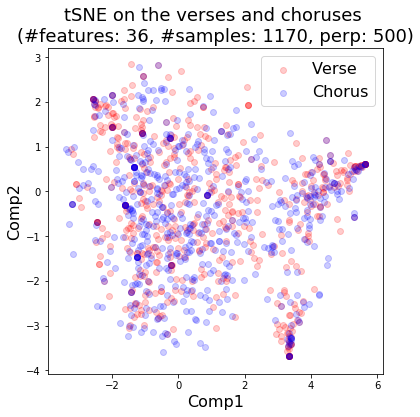

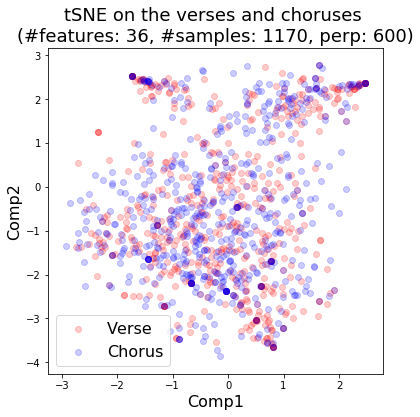

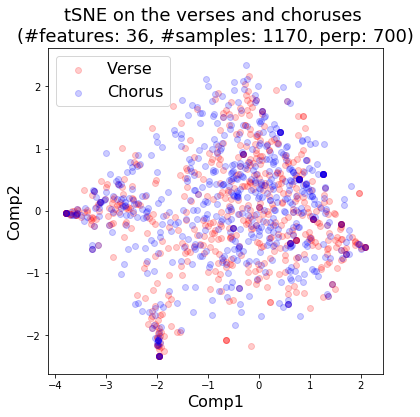

In [88]:
for perp in [30, 50, 70, 100, 150, 200, 300, 400, 500, 600, 700]:
    TSNE_visualization(df_verse = df_bow_verse_agg, 
                   df_chorus = df_bow_chorus_agg, 
                   vocab = features_agg,  
                   perplexity = perp)

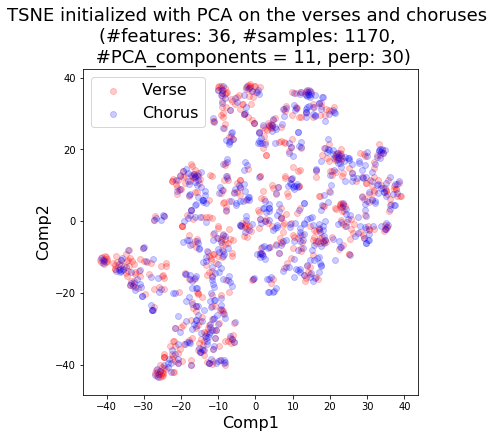

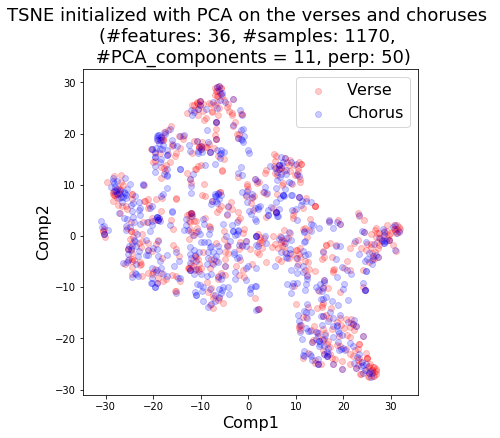

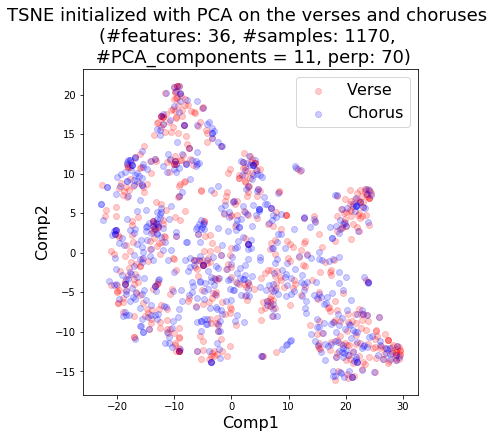

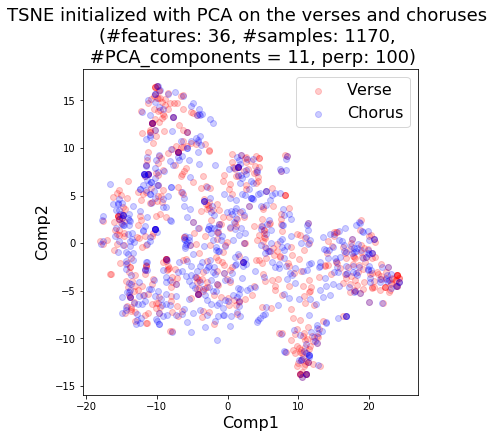

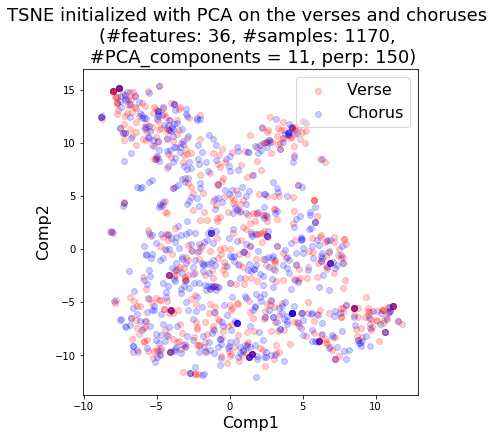

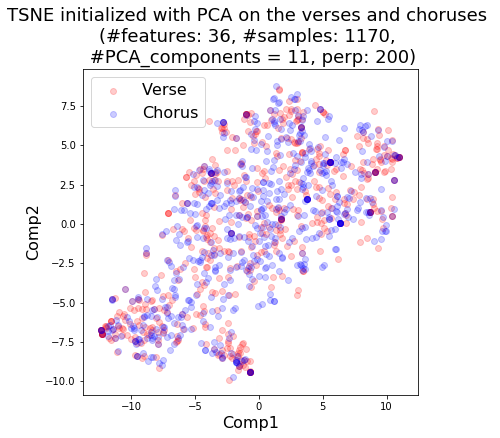

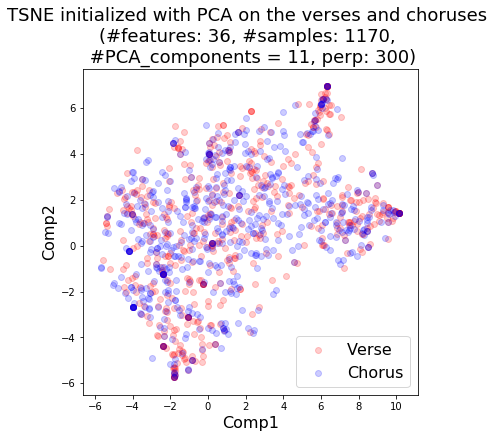

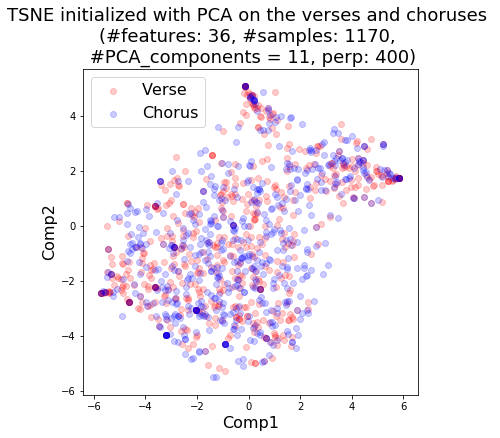

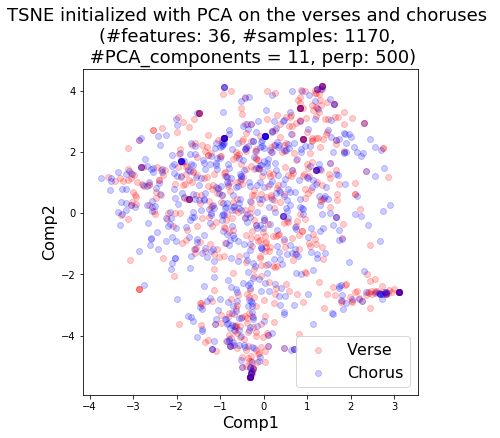

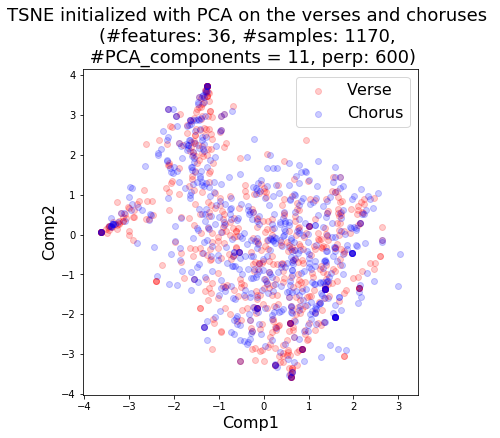

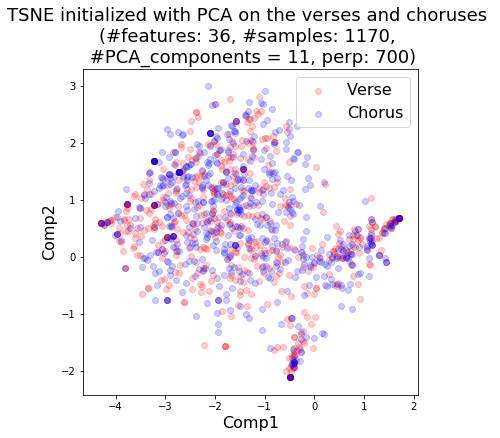

In [89]:
for perp in [30, 50, 70, 100, 150, 200, 300, 400, 500, 600, 700]:
    TSNE_PCAinit(df_verse = df_bow_verse_agg, 
                 df_chorus = df_bow_chorus_agg,
                 vocab = features_agg,
                 pca_comps = 11,
                 perplexity = perp)

For t-SNE, we have tried different perplexity values, both with and without PCA initialization, but the algorithm wasn't able to cluster the data in any meaningful way. Some soft clusters might be present but overall it is extremely noisy and it is fairly safe to conclude that t-SNE is not a suitable method to visualize this dataset in a low-dimension space.

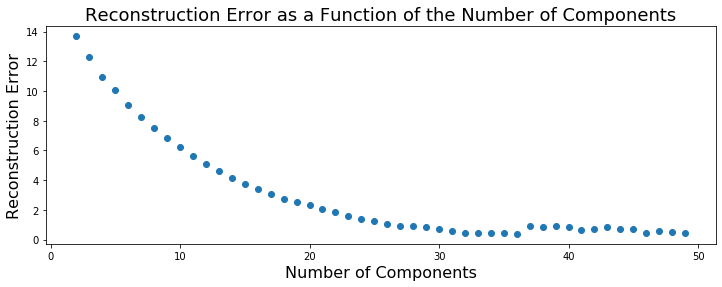

In [90]:
NMF_Optimization_NumberComponents(df_verse = df_bow_verse_agg, 
                                  df_chorus = df_bow_chorus_agg, 
                                  vocab = features_agg, 
                                  max_n_comp = 50)

When plotting the reconstruction error of the NMF model as a function of the number of components, we find that at least 26-27 components are required to stabilize the error below 1.

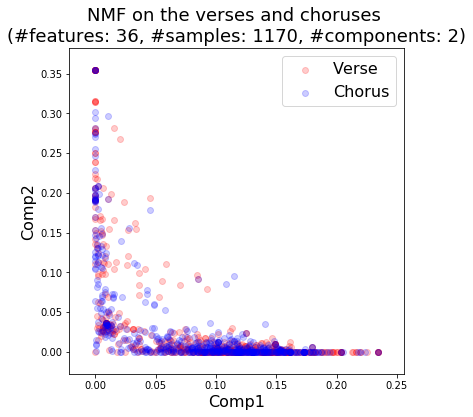

Reconstruction error: 13.67


In [91]:
nmf_model_agg = NMF_visualization(df_verse = df_bow_verse_agg, 
                                  df_chorus = df_bow_chorus_agg, 
                                  vocab = features_agg, 
                                  n_comps = 2)

With the 2D plot, the reconstruction error is still quite high but we get two characteristic groupings when considering one of the two components equal to 0 (note that this behaviour is already present with previous representations).

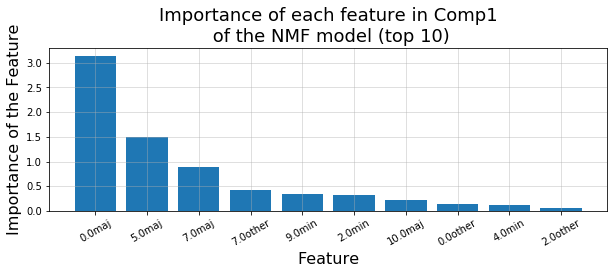

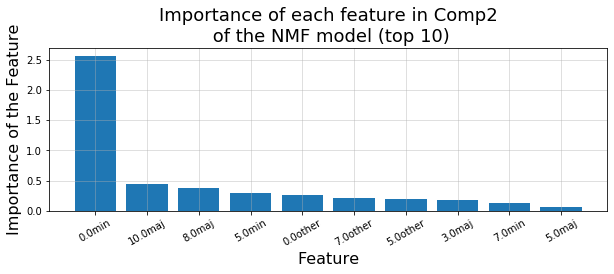

In [92]:
InspectNMFWeightVectors(weights = nmf_model_agg.components_, 
                        vocab = features_agg, 
                        n_comps = 2, 
                        n_weights = 10)

Inspecting the corresponding weights, we find that the first component relies mostly on major chords, with higher weights on tonic and dominant major chords, while the second component is mainly affected by tonic minor chords. Since major chords are the most present in the verses and choruses of our corpus, it makes sense that the biggest cluster identified by NMF is spread across values of the first component.

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5;">
    <strong>Conclusion:</strong> by relying on Bag of Words representations with three sets of features (absolute, relative-to-the-tonic or aggregated) and two representations of sequences of a given type (concatenated or individual sequences), we have discussed whether dimensionality reduction methods are able to differentiate between choruses and verses. <br>
    In order to do so, we have tested four methods: PCA, ICA, t-SNE (both with full initialization and PCA initialization) and NMF. Even though using aggregated features as allowed us to reduce the number of principal components required to preserve 90% of the variance in the data to 11, it is still difficult to observe clear distinctions between choruses and verses. It would rather seem that the differences observed and reflected on the different weights associated to each feature mostly tend to discriminate between different kind of songs. Thus it is fairly safe to conclude that the dimensionality reduction methods tested are not able to go beyond the differences between songs when using a Bag of Words representation, whether the sequences of considered individually or concatenated. <br>
    Furthermore, we have shown that t-SNE is not able to find any meaningful clustering, even by varying the perplexity on a large scale of values. It would seem this algorithm is not adapted to cast this dataset in a low-dimensional space.
</div>

## Chord Group Analysis

<div style="border:1px solid black; padding:10px 10px; background-color: #FBE7C6;"> 
     On the hypothesis that the chorus is a subset of the verse we have investigated the differences between the sets of chords in the verses and in the choruses.

Our analysis have shown that the hypothesis is not confirmed, it is even slighty the opposite. The verses and choruses share on average 80% of their chords, with the chorus being richer in 41% of the songs and the verse in 30 % of the songs. We have looked into each of these groups to see if we could find any relevant differences.
</div>

### Method

Each song is analysed in a set representation of their chords. The chords are assigned to the group chorus, verse, or both in regards to where they appear. For instance a chord 7min found in only the chorus will go in the set "chorus_only". The result are three sets with no matching chords. The sets chorus and verse holding the most element give their name to the majority, in case of equality it is tagged "equal".
For the sake of clarity we have chosen to simplify the data by using again the aggregated features, defined by the relative-to-the-tonic root and 3-labels categorization of the chord quality (major, minor or other).

In [96]:
#functions to prepare the dataset of subsets

def chord_to_lists(chord_lists):
    array=[]
    for chord_list in chord_lists :
        for chord in chord_list:
            array.append(chord)
    return (list(set(array)))


def length_of_set(df,subset,majority=""):
    if(majority!=""):
        b=pd.DataFrame(df[df["majority"]==majority][subset].map(lambda y: len(y)))
    else:
         b=pd.DataFrame(df[subset].map(lambda y: len(y)))
    b=b[b[subset]!=0]
    return b[subset]


def compare(chorus_verse) :
    '''
    This function compares two lists to create a dictionary with the lists of the chords 
    found only in the chorus (chorus_only), verse (verse_only) and both (intersection).
    The longest vector is also placed in the section majority, and the ratio compares 
    the overlap of the chorus and verse (chorus/verse in case that the verse is more diverse 
    than the chorus and vice versa). 
    '''
    chorus=chorus_verse[0].copy()
    verse=chorus_verse[1].copy()
    length_chorus=len(chorus)
    length_verse=len(verse)  
    data={}
    data["intersection"]=[]
    data["chorus_only"]=chorus.copy()
    data["verse_only"]=verse.copy()
    data["majority"]=""
    data["ratio"]=0
    
    if(length_chorus>length_verse) :
        for element in verse :
            if(element in chorus) :
                data["intersection"].append(element)
                data["verse_only"].remove(element)
                data["chorus_only"].remove(element)
        data["ratio"]= len(data["intersection"])/length_verse   
        data["majority"]="chorus"
    else :
        for element in chorus :
            if(element in verse) :
                data["intersection"].append(element)
                data["verse_only"].remove(element)
                data["chorus_only"].remove(element)
        data["ratio"]=len(data["intersection"])/length_chorus
        if(length_chorus==length_verse) :
            data["majority"]="equal"
        else :
            data["majority"]="verse" 
    return data

In [121]:
###Prepare the chords to match the line of fifth according to their simplified version 
keys_sets = beats_collection_df["agg_chord_label"].unique()
fifth = [6,11,4,9,2,7,0,5,10,3,8,1]
fifth_shorthand=[]
for chord in fifth :
    for short in ["maj", "min", "other"]:
        fifth_shorthand.append(str(chord) + short)
keys_sets = fifth_shorthand


def appender(target, vector):
    if(len(vector) == 0):
        return
    for element in vector:
        target.append(element)

def plot_groups(groups,subgroups,columns_name, title):
    
    df=plot_group(groups[0],subgroups,select_shorthand='none',plot=False)
    for i in range(1,len(groups)):
        df_temp=plot_group(groups[i],subgroups,select_shorthand='none',plot=False)
        df=pd.concat([df,df_temp],axis=1,sort=False)
    df.columns=columns_name
    df.iplot(kind="bar",barmode="group",title=title,xTitle="Chord name", yTitle="% of songs") 

        
def plot_group(df,groups,in_percent=True,select_shorthand='none', title="",plot=True):
    '''
    Takes a dataset of lists and returns the plot
        df: DataFrame
        groups: which sets to plot
        in_percent: Normalize the data
        select_shorthand: shorthand nototation to filter the results
        title: title of the graph
        plot: If false will return the data_frame instead of the plot
    '''
    normalizer=len(df.index)
    df_plot=pd.DataFrame(index=keys_sets)
    
    #Each list is made into a merged vector to be counted and then added to the 
    #dataset df_plot
    for group in groups:
        vector_intersection=[]
        df[group].map(lambda y: appender(vector_intersection,y))
        c=Counter(vector_intersection)
        c=pd.DataFrame(c.items(), columns=["chord", group])
        if(in_percent):
            c[group]=c[group].map(lambda y:y*100/normalizer)
        c=c.set_index("chord")
        df_plot=pd.concat([df_plot,c], axis=1,sort=False)
        
    df_plot.fillna(0,inplace=True)
    #shorthand filter
    if(select_shorthand != 'none'):
        df_plot=df_plot[df_plot.index.str.contains(select_shorthand)== True]
    
    if(plot):
        df_plot.iplot(kind="bar",barmode="group",title=title,xTitle="Chord name", yTitle="% of songs")   
    else:
        return df_plot

A dataset containing the intersections of the sets of unique chords is created for each song.
"Verse_only" denotes the chords only found in the verse, "Chorus_only" in the chorus, and intersection in both. 
The "majority" column indicates which of the previously mentioned category is the most diverse (longest vector). 

In [99]:
chord_lists = beats_collection_df[(beats_collection_df["section_type"] == "chorus") | (beats_collection_df["section_type"] == "verse")]
chord_lists = squeeze_section(chord_lists)
chord_lists = chord_lists.groupby(["song_id", "section_type"]).agg_chord_label.agg(chord_to_lists)
chord_lists = pd.DataFrame(chord_lists)

intersection=pd.DataFrame(chord_lists.groupby(["song_id"]).agg_chord_label.agg(compare))
for key in ["intersection", "majority", "ratio", "verse_only", "chorus_only"]:
    intersection[key]=intersection.agg_chord_label.map(lambda y: y[key])
intersection.drop(columns = "agg_chord_label", inplace=True)

In [100]:
intersection.head(5)

intersection majority  ratio  \
song_id                                                     
4              [0.0maj, 2.0min, 7.0other]   chorus    0.6   
10       [0.0maj, 5.0maj, 2.0min, 7.0maj]   chorus    1.0   
12               [0.0maj, 5.0maj, 7.0maj]   chorus    1.0   
16              [0.0min, 10.0maj, 8.0maj]   chorus    1.0   
18                       [0.0maj, 0.0min]    equal    0.4   

                        verse_only                          chorus_only  
song_id                                                                  
4               [4.0other, 9.0min]  [4.0min, 0.0other, 10.0maj, 5.0maj]  
10                              []                            [10.0maj]  
12                              []             [4.0maj, 2.0min, 4.0min]  
16                              []           [3.0maj, 7.0other, 5.0min]  
18       [8.0maj, 10.0maj, 5.0min]             [9.0min, 7.0maj, 5.0maj]

In [103]:
print(intersection["majority"].value_counts().map(lambda x: 100 * x / intersection["majority"].value_counts().sum()))

chorus    41.367521
verse     29.914530
equal     28.717949
Name: majority, dtype: float64


41% of the songs find more diversity in the chorus than verse, 30% in the verse, and 29% of the songs are equally distributed between the two.

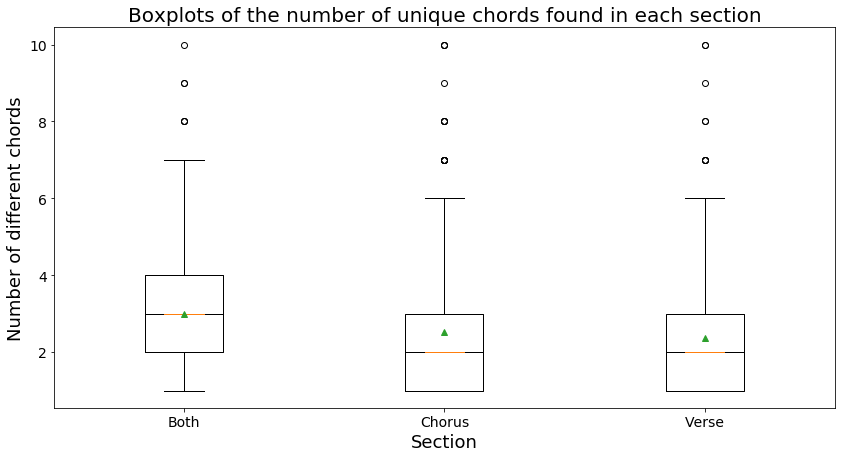

In [107]:
data_length = []
for key in ["intersection", "chorus_only", "verse_only"] :
    data_length.append(length_of_set(intersection,subset = key))
    
plt.figure(figsize = (14,7))
plt.boxplot(data_length, 
            notch = True, 
            bootstrap = 5000, 
            showfliers = True, 
            showmeans = True)
plt.title('Boxplots of the number of unique chords found in each section', fontsize = 20)
plt.xticks([1,2,3], ['Both', 'Chorus', 'Verse'], fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Section', fontsize = 18)
plt.ylabel('Number of different chords', fontsize = 18)
plt.show()


We observe that the number of chords appearing only in the chorus and in the verse and extremely similar in terms of distribution.

The ratio of the groups could inform us on the presence of subsets of one another. If more elements are found in the chorus than the verse then the length of the intersection is divided by the length of the chorus and vice versa if the verse is longer. This value is stored in the ratio column.  

Ratio = length(intersection)/length(chorus)

in the case that length(chorus)>length(verse)

One can observe no significant difference between the verse and chorus in termes of belonging to one another. And they share on average 80% of their chords.

In [108]:
#Three sub datasets based on each category of majority
sub_chorus=intersection[intersection["majority"] == "chorus"]
sub_verse=intersection[intersection["majority"] == "verse"]
sub_equal=intersection[intersection["majority"] == "equal"]

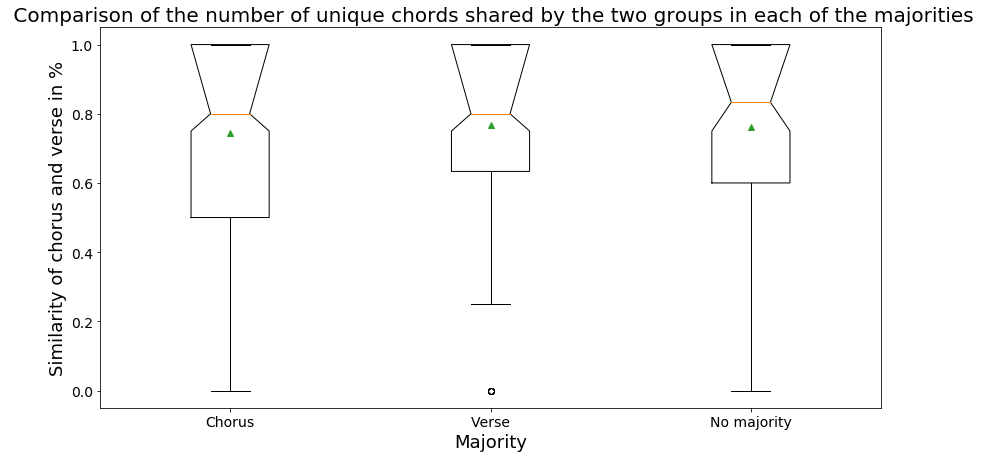

In [112]:
data_chords = []
intersection["ratio"] = intersection.ratio.map(lambda x: 100 * x)
data_chords.append(sub_chorus.ratio)
data_chords.append(sub_verse.ratio)
data_chords.append(sub_equal.ratio)



plt.figure(figsize = (14,7))
plt.boxplot(data_chords, 
            notch = True, 
            bootstrap = 5000, 
            showfliers = True, 
            showmeans = True)
plt.title(' Comparison of the number of unique chords shared by the two groups in each of the majorities', fontsize = 20)
plt.xticks([1,2,3], [ 'Chorus', 'Verse', 'No majority'], fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Majority', fontsize = 18)

plt.ylabel('Similarity of chorus and verse in %', fontsize = 18)
plt.show()

In [122]:
plot_group(df = intersection, 
           groups = ["verse_only","chorus_only","intersection"], 
           title = "Proportion of unique chords found in each section" )

In [127]:
plot_group(df = intersection,
           groups = ["verse_only","chorus_only"],
           title = "Proportion of unique chords found in each section (Intersection hidden)")
plot_group(df = intersection,
           groups = ["verse_only","chorus_only"],
           select_shorthand = "maj", 
           title = "Proportion of unique chords found in each section '(Major chords)" )
plot_group(df = intersection,
           groups = ["verse_only","chorus_only"],
           select_shorthand = "min",  
           title = "Proportion of unique chords found in each section (Minor chords)" )

In [126]:
a = plot_group(df = sub_chorus, 
               groups = ["chorus_only"], 
               plot = False)
b = plot_group(df = sub_verse, 
               groups = ["verse_only"], 
               plot = False)
a = pd.concat([b,a], axis = 1, sort = False)
a.columns = ["verse_majority", "chorus_majority"]
a.iplot(kind = "bar", 
        barmode = "group", 
        title = "Comparison of chord distribution in chorus and verse majority", 
        xTitle = "Chord name", 
        yTitle= "Number of songs [%]") 

a = plot_group(df = sub_chorus, 
               groups = ["chorus_only"],
               select_shorthand = "maj",
               plot = False)
b = plot_group(df = sub_verse,
               groups = ["verse_only"], 
               select_shorthand = "maj",
               plot = False)
a = pd.concat([b,a], axis = 1, sort = False)
a.columns = ["verse_majority", "chorus_majority"]
a.iplot(kind = "bar",
        barmode = "group",
        title= "Comparison of chord distribution in horus and verse majority (Major chords)",
        xTitle = "Chord name", 
        yTitle = "Number of songs [%]") 


a = plot_group(df = sub_chorus,
               groups = ["chorus_only"],
               select_shorthand = "min",
               plot = False)
b = plot_group(df = sub_verse,
               groups = ["verse_only"], 
               select_shorthand = "min",
               plot = False)
a = pd.concat([b,a], axis = 1, sort = False)
a.columns = ["verse_majority", "chorus_majority"]
a.iplot(kind = "bar",
        barmode = "group",
        title = "Comparison of chord distribution in horus and verse majority (Minor chords)",
        xTitle = "Chord name", 
        yTitle = "Number of songs [%]") 


In the last two graphs we can observe that the chords found in the chorus majority subset have a tendency to be more major and less minor than in the verse majority. 

##### Comments: 
The results that we have found are more due to the difference between two types of songs (chorus-oriented and verse-oriented) than it is a result of true differences between chorus and verse. They are highly linked together inside songs and outside as well. We cannot ignore the fact that by reducing the initial group in three sub-parts we raise the probability of finding false results by raising the variance. As can be seen in the following graph, plotting only the songs where the diversity of chords is the same in both the chorus and verse, we find differences conflicting with the previous ones. And thus the intrinsic singularity of choruses and verses cannot be outlined. We would need more data to further investigate the results and be able to find meaningfull conclusions. As for now we cannot from our dataset of chords draw any conclusion on how a chorus is made with respect to its verse or how different they are in general. 

In [125]:
plot_group(df = sub_equal,
           groups = ["verse_only", "chorus_only"],
           select_shorthand = "maj", 
           title = "Proportion of unique chords found in verse and chorus with same diversity- Major chords")
plot_group(df = sub_equal,
           groups = ["verse_only", "chorus_only"],
           select_shorthand = "min" ,
           title = "Proportion of unique chords found in verse and chorus with same diversity- Minor chords")

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5;">
    <strong>Conclusion:</strong> TO DO
</div>

## Musical Path analysis

<div style="border:1px solid black; padding:10px 10px; background-color: #FBE7C6;"> 
     ABSTRACT TO DO
</div>

Our first idea was to plot a "mean distance to the tonic" for each note position in melodic lines of different lengths. Unfortunatly, a "distance" for which a mean make sense in music was hard to define, as the relation between notes cannot be meaningfuly reduced to a one-dimensional measure.

Hence, we try to plot all paths of a given length on one graph, but this gave us no visual clue to define a difference. Eventually, we focused on heatmap of pitchclass occurences per position.

In [128]:
def temporal_squeeze(beats_collection_df, column, type, measurement = "relative_root_tpc"):
    """
    Similar to squeeze function. Create a dataframe where each row contains a list of successive chords
    beats_collection_df : the input dataframe
    column : the identifier that distinguish what is a chord sequence (measure, line, section, ...)
    type : the type of song section to be considered, chorus or verse
    measurement : what form of the chords will be put in the lists
    """
    
    selected_df = beats_collection_df[beats_collection_df.section_type == type]
    
    agg_df = selected_df.groupby(["song_id",column])[measurement].apply(list).reset_index()
    
    return agg_df

In [129]:
chorus_section_df = temporal_squeeze(beats_collection_df,"sequence_id","chorus")
verse_section_df = temporal_squeeze(beats_collection_df,"sequence_id","verse")

In [130]:
def show_most_common(df, column, type, measurement="relative_root_tpc"):
    """
    Show the most common lengths of chords lists in a given dataframe and add a "length" column to the dataframe
    df : the input dataframe
    column : what represent the chord list : measure, line, section...
    type : the type of song section to be considered, chorus or verse
    measurement : the form of the chord in the list
    """
    df["length"] = df[measurement].apply(len)
    
    print("*Number of {} per length for {}*".format(column,type))
    print(df.groupby("length")[column].count().sort_values(ascending = False).head(10)\
     .reset_index().rename(columns = {column:"Quantity"}))
    print()

In [131]:
show_most_common(chorus_section_df,
                 column = "sequence_id",
                 type = "chorus")
show_most_common(verse_section_df,
                 column = "sequence_id",
                 type = "verse")

*Number of sequence_id per length for chorus*
   length  Quantity
0      32       705
1      64       231
2      48       157
3      16       134
4      36        87
5      40        79
6      24        74
7      28        56
8      56        37
9      72        30

*Number of sequence_id per length for verse*
   length  Quantity
0      32       554
1      64       442
2      48       120
3      36        46
4      40        45
5      16        38
6      24        36
7      56        32
8      68        29
9      72        27



As we have no way to normalize the length of a musical path (We have no guarantee, for exemple, that the second chord of a path of length 3 will play the same role as a "mean chord" of first and second chords in a path of length 2), we analyse each path length on its own. For statistical signifiance sake, we decided to consider only the paths lengths with more than 100 representent in both choruses and verses. 

In [134]:
section_lengths = (32,64,48)

In [135]:
def create_heatmap_df(df,length,measurement = "relative_root_tpc"):
    """
    Turn a dataframe input a heatmap-suitable dataframe
    df : the input dataframe
    length : the length of chords lists considered
    measurement : the form of the chords in the lists
    Return : a dataframe where rows are pitch classes, columns are temporal positions
    and values are the proportion of occurences of given pitch class at given position
    """
    
    selected_df = df[df.length == length]
    
    heatmap_df = pd.DataFrame()
    
    for i in range(length):
        
        pname = "pos {}".format(i)
        
        selected_df[pname] = selected_df[measurement].apply(lambda l: l[i])
        selected_df = selected_df.astype({pname:"Int64"})
        
        heatmap_df[pname] = selected_df[pname].value_counts()
        
        #Normalisation
        heatmap_df = heatmap_df/heatmap_df.sum(axis = 0)
        
        heatmap_df.index.name = measurement
        
    return heatmap_df.sort_index(ascending=False)
    
        
def create_heatmaps(chorus_df,verse_df,length,measurement = "relative_root_tpc"):
    """
    Plot heatmaps for choruses, verses and difference chorus - verse
    chorus_df and verse_df : the input dataframes
    length : the length of chords lists considered
    measurement : the form of the chords in the chords lists
    """
    heatmap_chorus = create_heatmap_df(chorus_df,length)
    heatmap_verse = create_heatmap_df(verse_df,length)
    heatmap_diff = (heatmap_chorus - heatmap_verse).sort_index(ascending=False)
    
    fig, axs = plt.subplots(ncols=2,figsize=(40,12))
    
    sns.heatmap(heatmap_chorus, ax = axs[0])
    axs[0].set_title("Pitch class per position for choruses of length {}".format(length))
    #plt.show()
    
    sns.heatmap(heatmap_verse, ax = axs[1])
    axs[1].set_title("Pitch class per position for verses of length {}".format(length))
    plt.show()
    
    plt.figure(figsize = (30,18))
    sns.heatmap(heatmap_diff)
    plt.title("Difference in pitch class occurences (length {})".format(length))
    plt.show()
    
    return 0
    

Each of these heatmaps represents the proportion of transposed-to-C roots of each pitch class for each given beat position, considering all choruses, all verses, and then the difference between the two. 

In other words, for a given length and a given section, for pitch class i, position j, number of sections n, we obtain a matrix whose values are :

$v(i,j) = \frac{\sum_{pos_j}I_{pitchclass=j}}{n}$

This computation is done for two types of sections: choruses and verses. The last matrix is given by:

$M_{difference} = M_{choruses} - M_{verses}$

The process is repeated for each selected length.

For the first two matrices, the sum of each column is equal to 1, to 0 in the last.

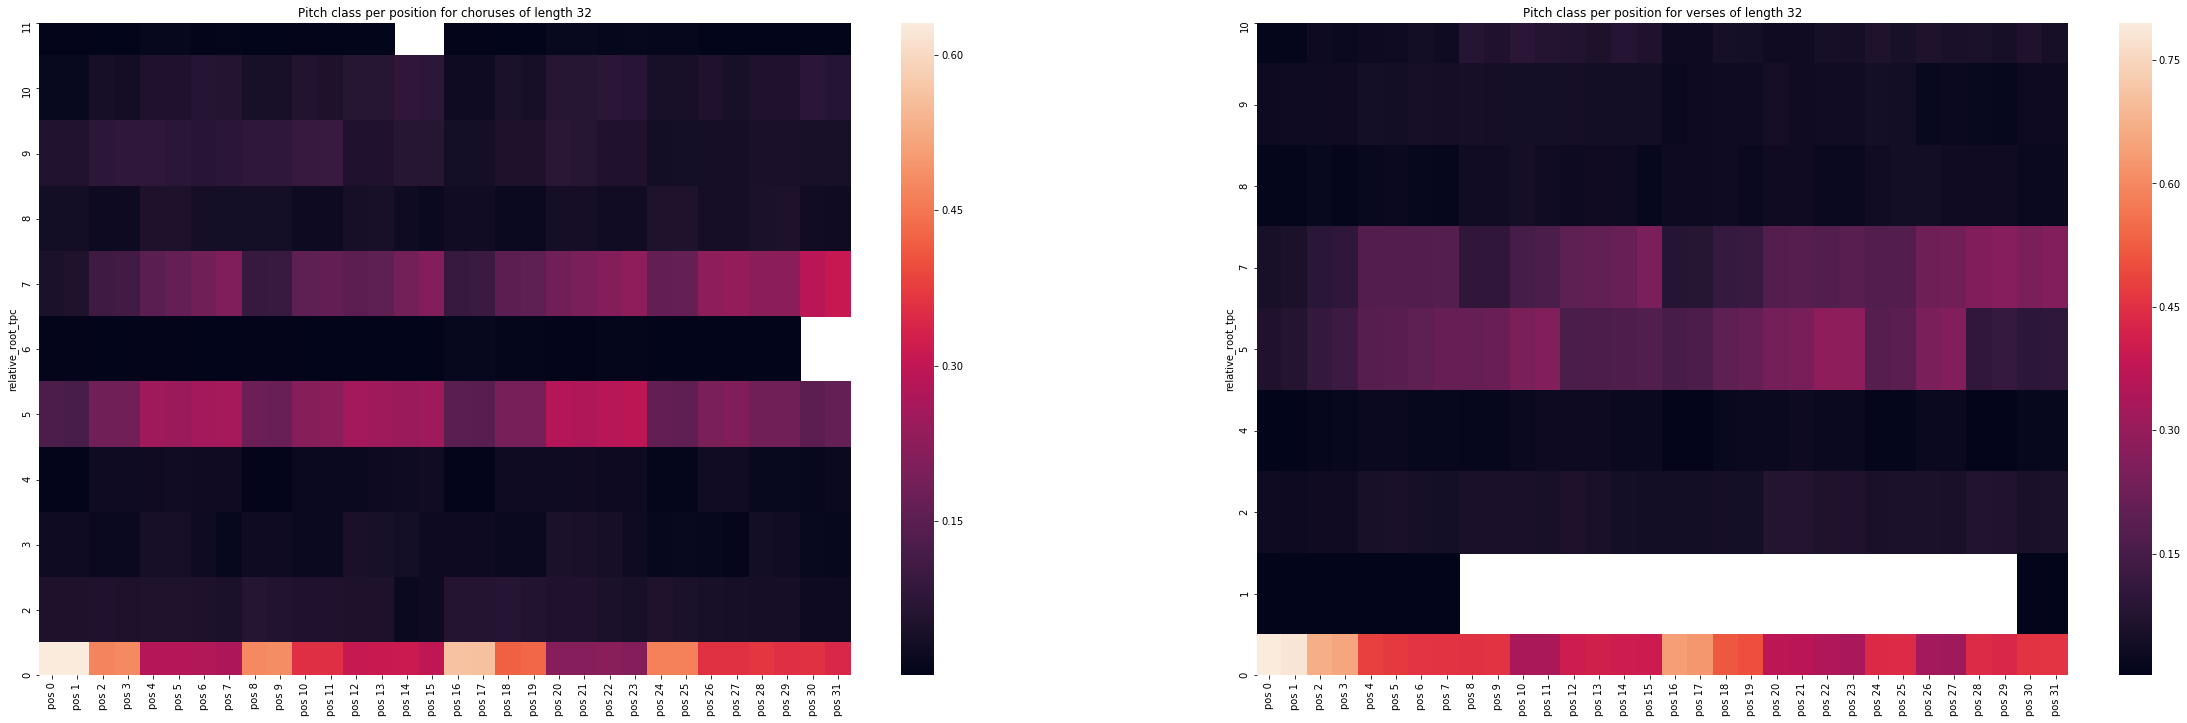

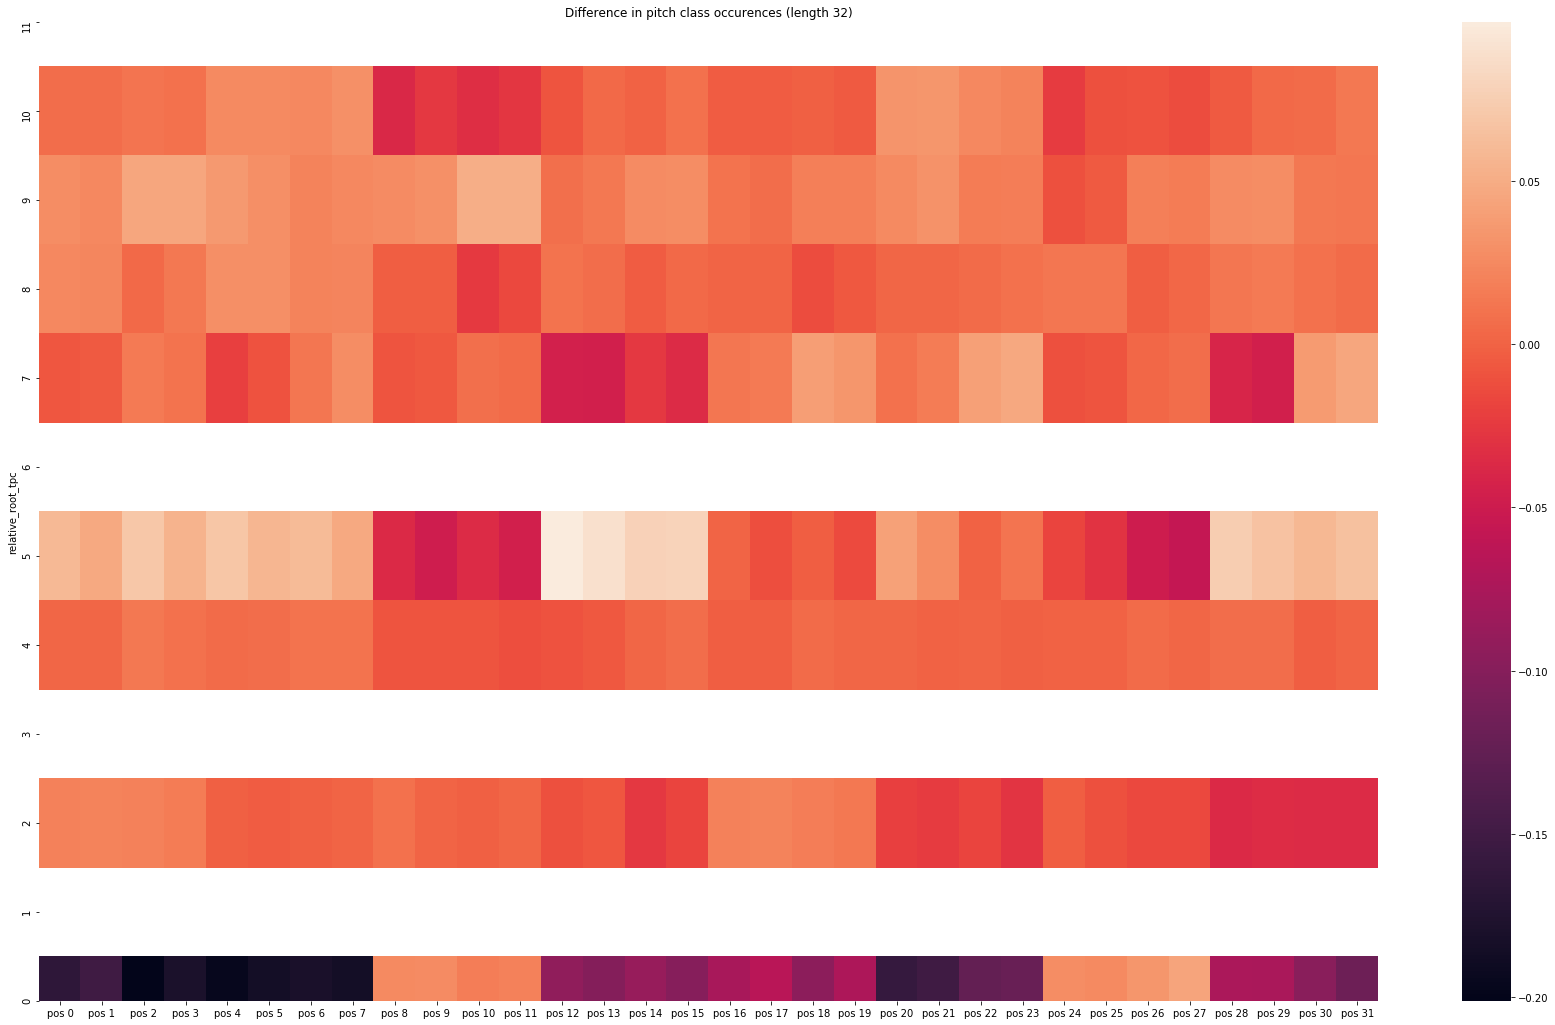

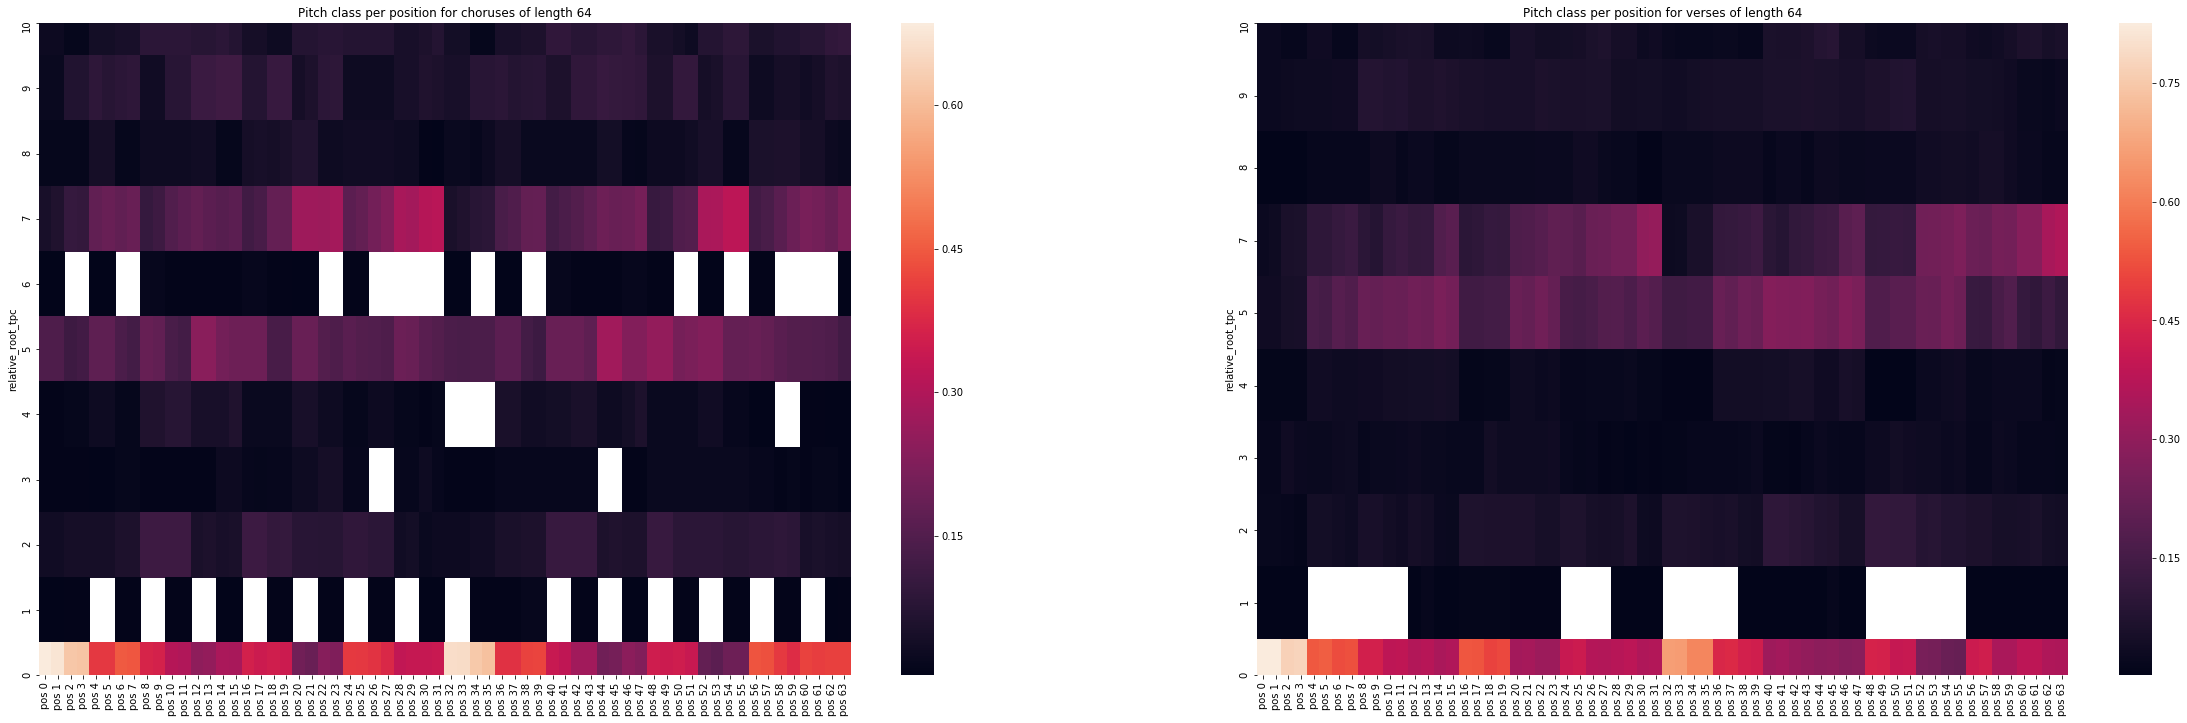

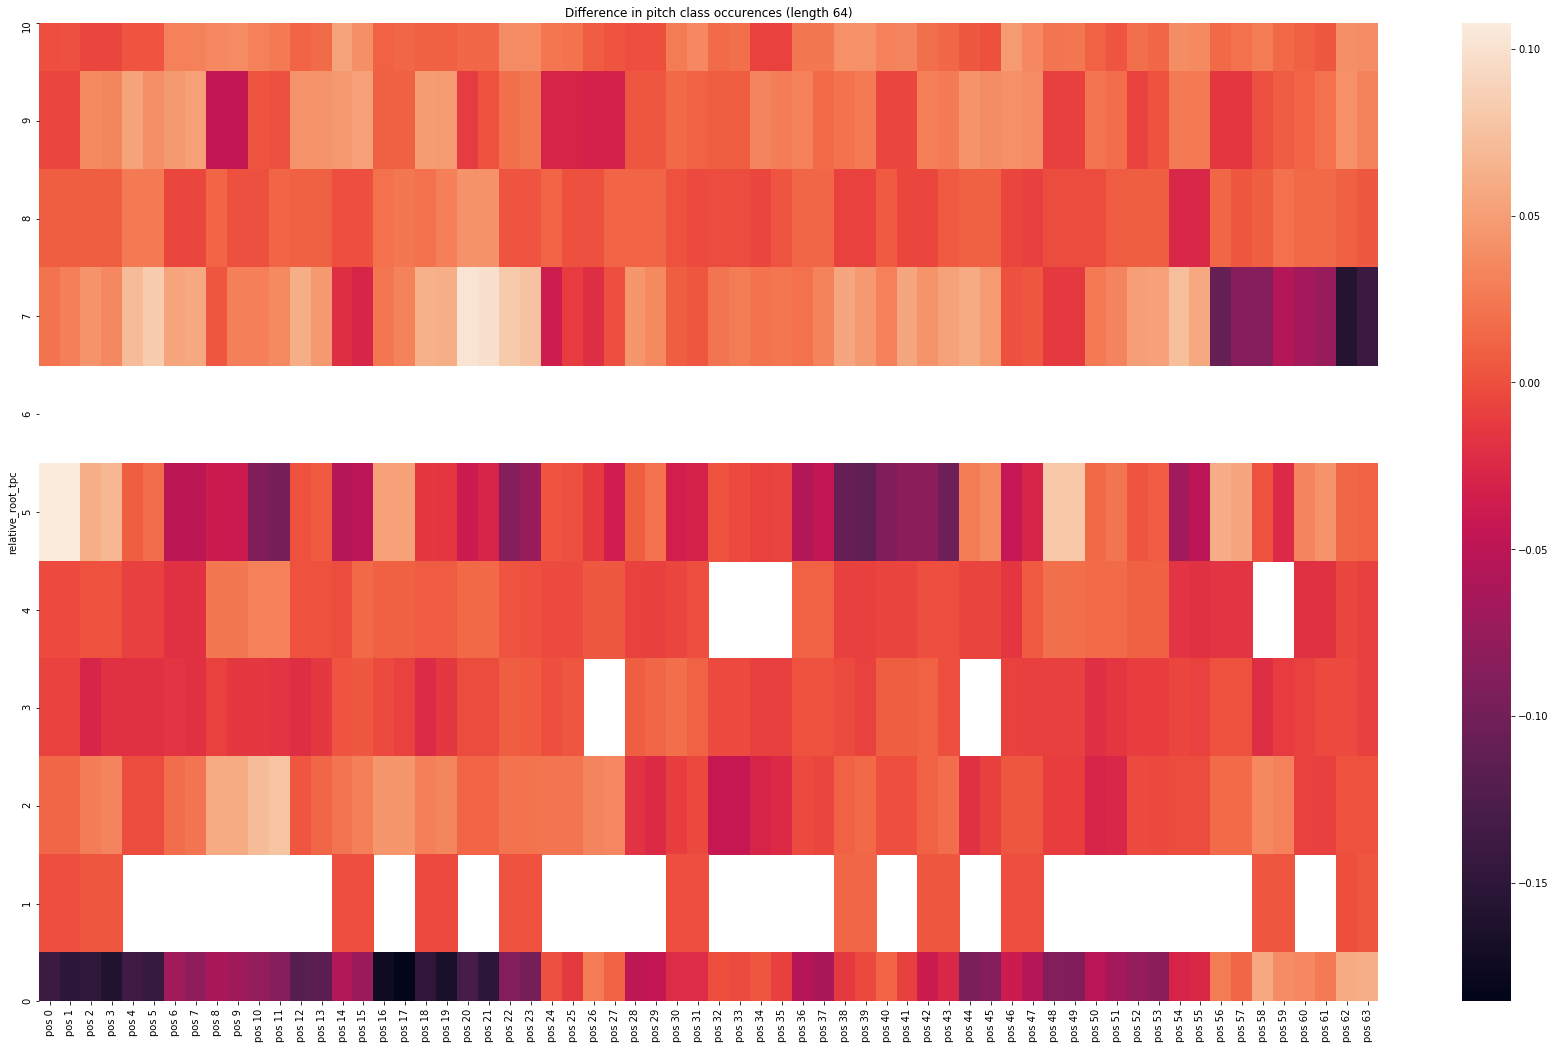

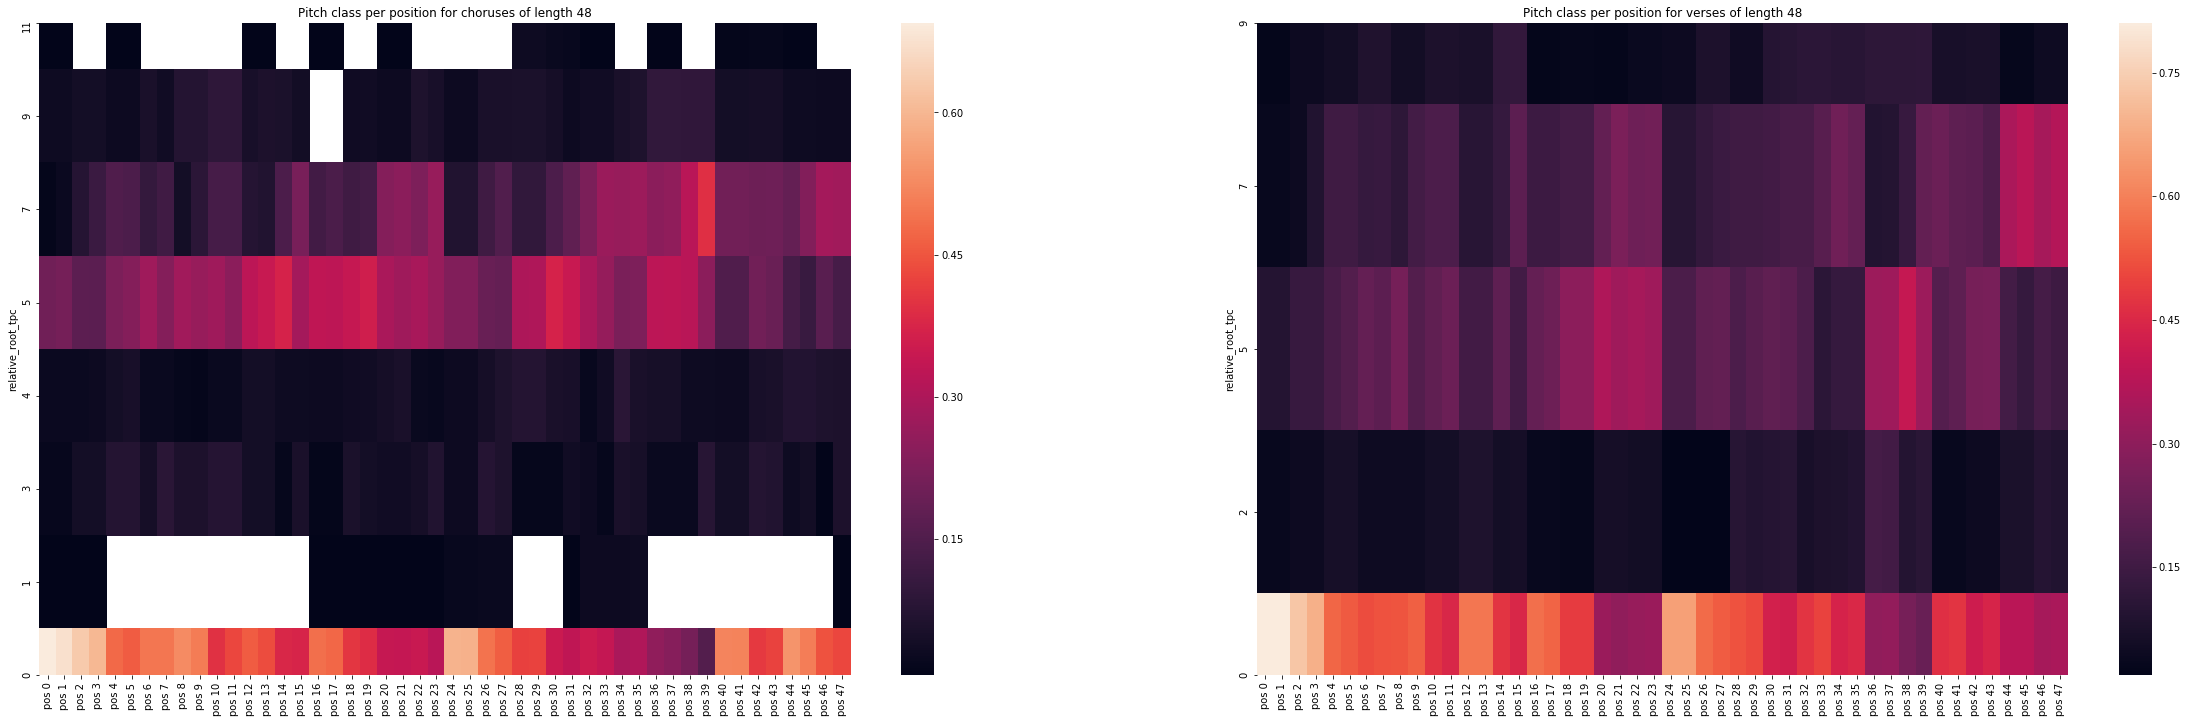

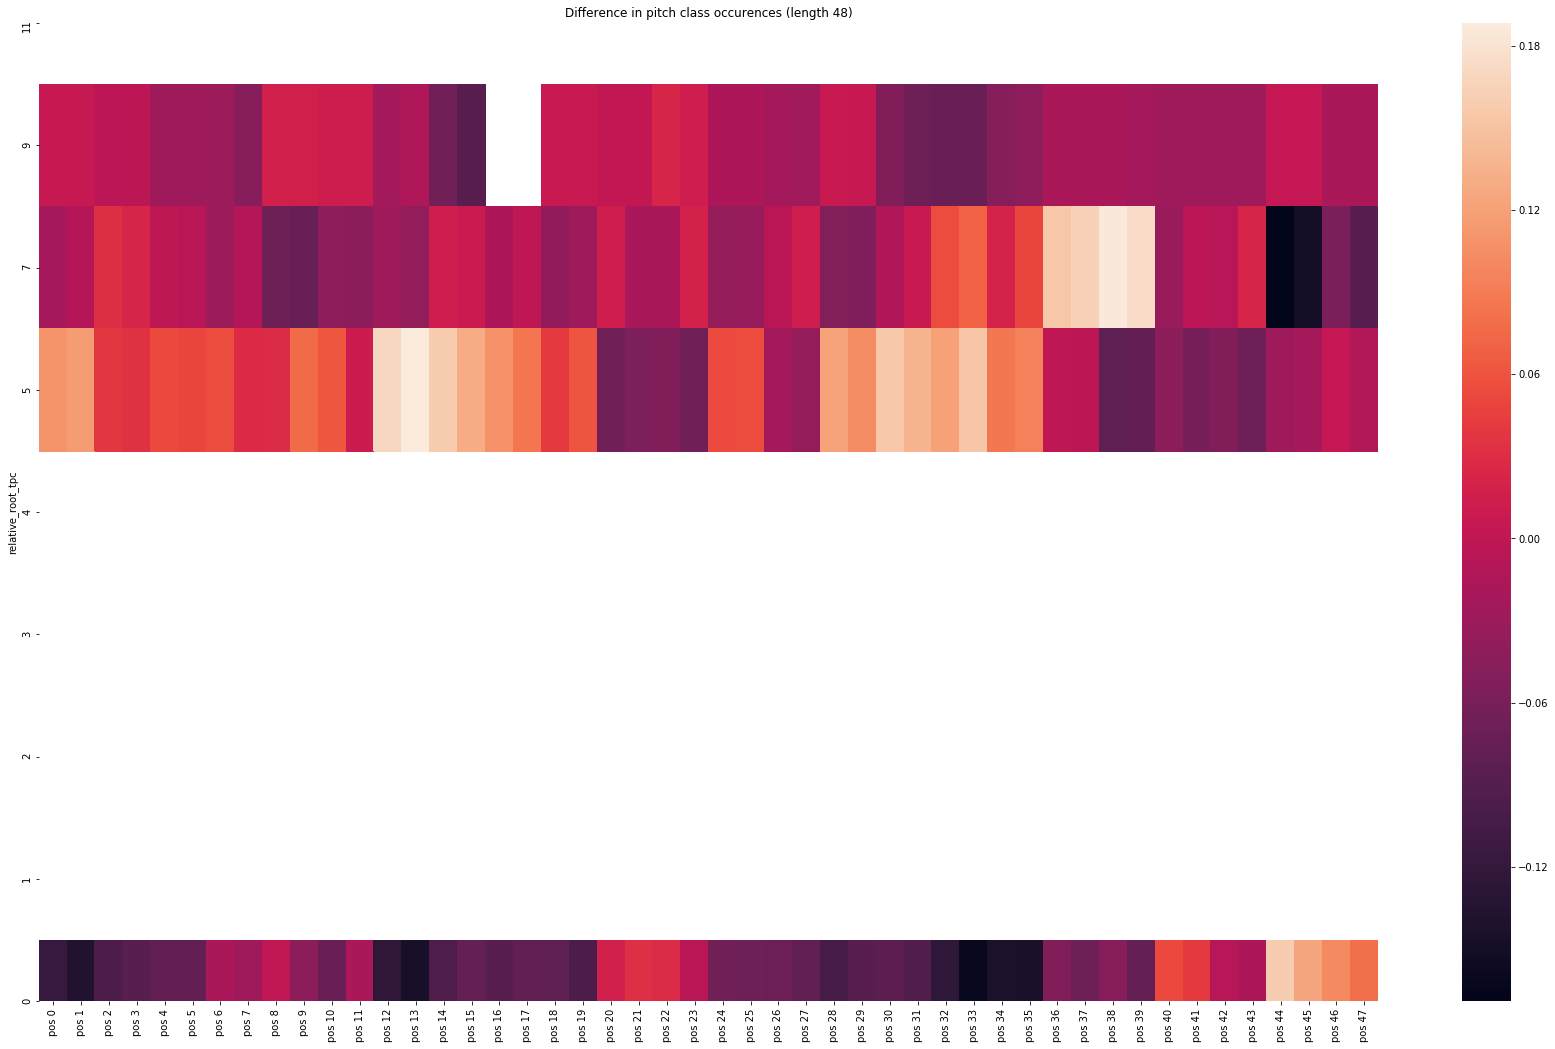

In [136]:
for i in section_lengths:
    create_heatmaps(chorus_section_df,verse_section_df,
                    length = i)

What interested us the most is the difference heatmap (the largest one).  Dark orange, pink or pure white means no difference. Light orange means that the pitch class at given position is more frequent in choruses. Dark blue means that it is more frequent in verses.

We observe notable differences essentialy for pitch classes 0, 5 and 7 (the other pitch classes occur anyway very few in both choruses and verses). The most striking are the very dark zones for pitch class 0. Lengths 32 and 64 admit one on the five to seven first positions and a second centered around position 20. Length 48 also admits a zone in the first positions, although less strong, another centered at position 13 and a last centered at position 34.

For length 32, the correlation between less pitch class 0 in choruses and more pitch class 5 in verses for a given position is striking. Length 64 is caracterised by a maximum pitch class 5 ratio for the very first position and pitch class 7 for position 20. Length 48 admits also high proportion of class 5 for position 0, 13 and 34, and a pick of class 7 juste after, at position 38.

We observe an inverse effect at the end of the sections of length 64 and 48: pitch class 7 reach its lowest proportion and pitch class 0 its highest.

Overall, There are specific places in musical sections where the tonic plays a more important role in verses, and the fourth (5) and the fifth (7) a more important role in choruses. These places are: for length 32, the first measures and the four beats before position 24 (3/4 of the section) ; for length 64, the first beats and roughly 8 beats after position 16 (1/4 of the section) ; for length 48, the first beats, the 8 beats starting at position 12 (1/4 of the section) and from position 24 to 40 (1/2 to 5/6). The last four beats of length 64 and 48 show a reversed tendency.

Without surprise, all those numbers follow the standard partitioning of a melodic line in groups of length 2<sup>n</sup>.

We conclude that, contrary to our primary hypothesis, the verses tends to rely more on the "home", the tonic, to construct paths than the choruses, which give the most proeminent role to the dominant and the fourth. The opposite tendency at the end could be a lead to the other type of section, as often verses and choruses alternate.

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5;">
    <strong>Conclusion:</strong> TO DO
</div>

## Individual differences analysis

<div style="border:1px solid black; padding:10px 10px; background-color: #FBE7C6;"> 
     ABSTRACT TO DO
</div>

In this section, we plot each song as a 2D point, where its x-coordinate is a certain measure on its choruses and the y-coordinate the same measure on its verses.

The measure consist of a mapping from each chords to a value that interest us. The measures are then averaged within each section (chorus or verse) that belongs to each song. Then, the results from all sections of a same kind are averaged together within each song. This gives for each song two values, one for the choruses and one for the verses.

In other words, for a given song with a set of choruses C and a set of verses V, and a measure f:

$v_{choruses} = mean_{C}(mean_{C_i \in C}(f(chord),chord \in C_i))$

$v_{verses} = mean_{V}(mean_{V_i \in V}(f(chord),chord \in V_i))$

Along with the scatter plot, an independence t-test is used to check if the distribution of the choruses values are different to the distribution of the verses values. A p-value < 0.05 is considered significant.

In [137]:
# Creation of new dataframes with different form of chords
beats_collection_df["relative_tpc+shorthand"] = beats_collection_df.relative_root_tpc.apply(str) + ":" +\
beats_collection_df.shorthand

#Chords contains only the transposed to C tonic pitch class and the shorthands
chorus_tpcMm_section_df = temporal_squeeze(beats_collection_df,"sequence_id","chorus","relative_tpc+shorthand")
verse_tpcMm_section_df = temporal_squeeze(beats_collection_df,"sequence_id","verse","relative_tpc+shorthand")

# Only the shordhands
chorus_Mm_section_df = temporal_squeeze(beats_collection_df,"sequence_id","chorus","shorthand")
verse_Mm_section_df = temporal_squeeze(beats_collection_df,"sequence_id","verse","shorthand")

#The chords in their original notation
chorus_full_section_df = temporal_squeeze(beats_collection_df,"sequence_id","chorus","chord")
verse_full_section_df = temporal_squeeze(beats_collection_df,"sequence_id","verse","chord")

In [138]:
def mapping_average(df, measurement, type, f_mapping):
    """
    Apply a mapping function to the list of measurement, take the mean and average the means over each song.
    df : the input dataframe
    measurement : the form of the chords in the dataframe
    type : the type of chords sequences considered (measures, lines, sections, ...)
    f_mapping : the function that will be applied to each chord before aggregation
    Return : A dataframe where each song is associated to one aggregated value
    """
        
    df["mean_proximity"] = df[measurement].apply(lambda l : np.array(list(map(f_mapping, l))).mean())
    
    return df.groupby(["song_id"])["mean_proximity"].mean().reset_index()

In [139]:
def pitch_class_presence(df,pitch_class,measurement = "relative_root_tpc",type = "sequence_id"):
    """
    A variant of average_mapping that compute the ratio of occurence of a certain pitch class.
    df : the input dataframe
    pitch_class : the pitch class to consider
    measurement : the form of the chords in the dataframe
    type : the type of chords sequences considered (measures, lines, sections, ...)
    Return : A dataframe where each song is associated to the proportion of given pitch class in the given dataframe
    """
    ratio_pc = "ratio_{}".format(pitch_class)
    
    df["mean_proximity"] =\
    df[measurement].apply(lambda l : np.array([int(item == pitch_class) for item in l]).mean())
    
    return df.groupby(["song_id"])["mean_proximity"].mean().reset_index()

In [140]:
def proximity_tuple(chorus_df, verse_df, f_proximity):
    """
    For a chorus df and a verse df create the tuple of aggregated measures for chorus and verse in each song.
    chorus_df and verse_df : the input dataframes
    f_proximity : the function to be applied to each dataframe (can be for example an initiated mapping_average)
    Return : A list of tuples where each tuple contains the aggregated values for choruses and for verses for a song
    """
        
    proximity_chorus_df = f_proximity(chorus_df)
    proximity_verse_df = f_proximity(verse_df)
    
    tuple_df = proximity_chorus_df.merge(proximity_verse_df, on = "song_id")
    
    tuple_df = tuple_df.rename(
        columns = {"mean_proximity_x":"mean_chorus_proximity","mean_proximity_y":"mean_verse_proximity"})
    #Column x is chorus, column y is verse
    tuple_df["tuple"] =\
    tuple_df.apply(lambda row: (row["mean_chorus_proximity"],row["mean_verse_proximity"]),axis=1)
    
    return tuple_df["tuple"].values

In [141]:
def songs_plot(function,xlabel,ylabel,maxsize=1,minsize=0,
               chorus_df = chorus_section_df, verse_df = verse_section_df):
    """
    Plot the songs in a scatter plot with the centroid. Compute a t-test on the choruses and verses distributions.
    function : the aggregating function to apply to each dataframe
    xlabel, ylabel : the description of each axe
    maxsize,minsize : the extrema of the values that can take the aggregated results
    chorus_df, verse_df : the dataframes to use.
    """
    plt.figure(figsize=(7,7))
    chorus_verse_list = list(zip(*proximity_tuple(chorus_df, verse_df,function)))
    
    centroid = (np.array(chorus_verse_list[0]).mean(),np.array(chorus_verse_list[1]).mean())
    std = (np.array(chorus_verse_list[0]).std(),np.array(chorus_verse_list[1]).std())
    t_stat, p_value = scipy.stats.ttest_ind(chorus_verse_list[0],chorus_verse_list[1])
    n_dof = len(chorus_verse_list[0]) - 1 + len(chorus_verse_list[1]) - 1
    
    plt.scatter(*chorus_verse_list)
    plt.scatter(*centroid)
    plt.plot([minsize,maxsize],[minsize,maxsize],linestyle="-",color="k",linewidth=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    print("Centroid : ({:.4f},{:.4f})".format(centroid[0],centroid[1]))
    print("std are {:.4f} for choruses and {:.4f} for verses".format(std[0],std[1]))
    print("Independence t-test : t[{}] = {:.4f}, p-value = {:.4f}".format(n_dof,t_stat,p_value))

In [142]:
def pitch_class_plot(pitch_class,chorus_df = chorus_section_df, verse_df = verse_section_df):
    """
    Call songs_plot for a certain pitch class
    pitch_class : the given pitch class
    chorus_df, verse_df : the input dataframes
    """
    
    songs_plot(lambda df : pitch_class_presence(df,pitch_class),
              "Ratio of pitch class {} in choruses".format(pitch_class),
              "Ratio of pitch class {} in verses".format(pitch_class),chorus_df = chorus_df, verse_df = verse_df)

### Various measure on type of chords

We begin by measuring the difference in proportion between major and minor chords. Each major chord is weighted 1, each minor chord -1. Other chords are weighted 0. Major chords seems to be more present in choruses.

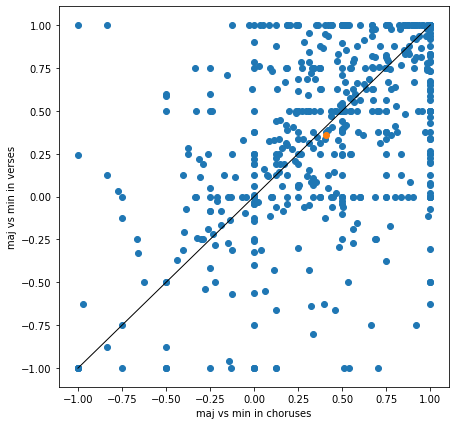

Centroid : (0.4084,0.3593)
std are 0.4722 for choruses and 0.5219 for verses
Independence t-test : t[1168] = 1.6861, p-value = 0.0920


In [147]:
songs_plot(function = lambda df: mapping_average(df,"shorthand","sequence_id",
                                    lambda s: 1 if s.startswith("maj") else -1 if s.startswith("min") else 0),
          xlabel = "maj vs min in choruses",ylabel = "maj vs min in verses",
           maxsize = 1,minsize = -1,
          chorus_df = chorus_Mm_section_df,verse_df = verse_Mm_section_df)

We also consider bass notes. The result is widely scattered, and shows a small preference for bass notes in verses.

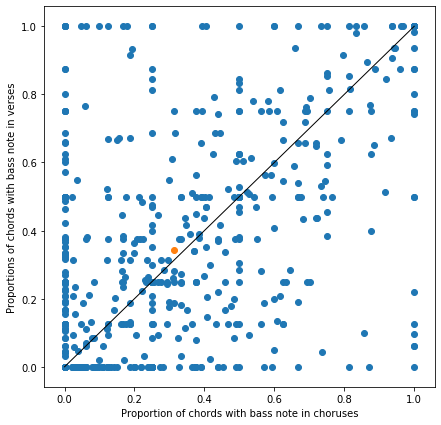

Centroid : (0.3117,0.3440)
std are 0.3105 for choruses and 0.3265 for verses
Independence t-test : t[1168] = -1.7344, p-value = 0.0831


In [148]:
songs_plot(function = lambda df : mapping_average(df,"chord","sequence_id",
                                       lambda c : 1 if c[-1].isdigit() else 0),
          xlabel = "Proportion of chords with bass note in choruses",
           ylabel = "Proportions of chords with bass note in verses",
           maxsize = 1,minsize = 0,
           chorus_df = chorus_full_section_df,verse_df = verse_full_section_df)

We also estimate the variety of chorus and verses by counting the number of unique chords (this is therefore not a per-chord mapping). Contrary to our hypotheses, no trend shows up.

In [149]:
def variety(df, measurement):
    """
    Give the mean number of unique chords per section"
    """
        
    df["mean_proximity"] = df[measurement].apply(lambda l : len(set(l)))
    
    return df.groupby(["song_id"])["mean_proximity"].mean().reset_index()

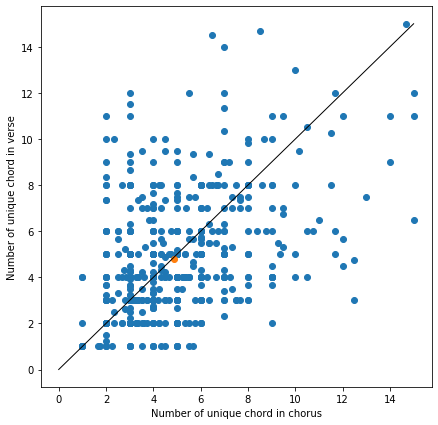

Centroid : (4.8626,4.8027)
std are 2.4443 for choruses and 2.5235 for verses
Independence t-test : t[1168] = 0.4123, p-value = 0.6802


In [150]:
songs_plot(function = lambda df : variety(df,"chord"),
           xlabel = "Number of unique chord in chorus",ylabel = "Number of unique chord in verse",
          maxsize = 15,minsize = 0,
           chorus_df = chorus_full_section_df,verse_df = verse_full_section_df)

### Pitch classes

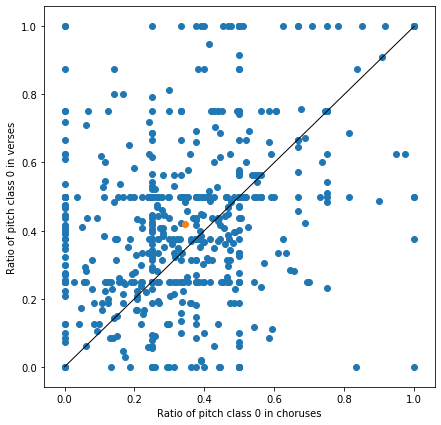

Centroid : (0.3459,0.4180)
std are 0.2113 for choruses and 0.2358 for verses
Independence t-test : t[1168] = -5.5042, p-value = 0.0000


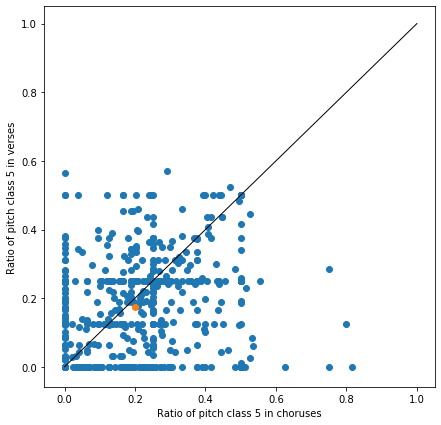

Centroid : (0.1993,0.1733)
std are 0.1608 for choruses and 0.1454 for verses
Independence t-test : t[1168] = 2.8926, p-value = 0.0039


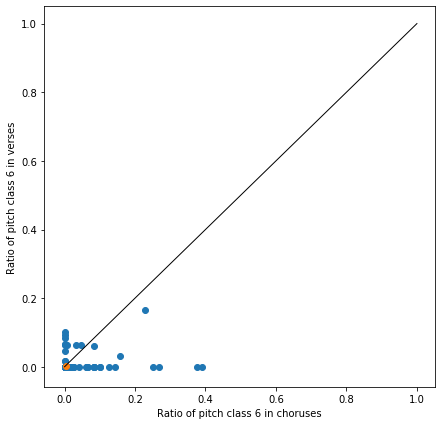

Centroid : (0.0052,0.0016)
std are 0.0321 for choruses and 0.0116 for verses
Independence t-test : t[1168] = 2.5667, p-value = 0.0104


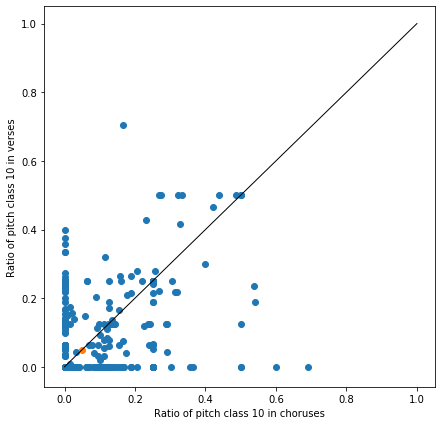

Centroid : (0.0504,0.0487)
std are 0.1068 for choruses and 0.1047 for verses
Independence t-test : t[1168] = 0.2810, p-value = 0.7788


In [151]:
for i in (0,5,6,10):
    pitch_class_plot(pitch_class = i)
    plt.show()

We plot for each song the proportion of chords with a transposed-to-C root of a certain pitch class among all chords in choruses, respectively in verses.

Among all plots, only two shows a centroid significantly skewed : pitch class 0 and 5. We also plot pitch class 6 to show a least significant result, where only the std clearly differs between choruses and verses, and pitch class 10 to show a pitch class that seems to perfectly centered.

What is interesting in these graphs is to look at patterns. For pitch class 0, two lines appears and show a significant amount of choruses with no tonic chords and of verses with only tonic chords. The opposite (choruses with only tonic chords and verses with no tonic chords) is least frequent.

For pitch class 5, a strong line appears for pitch class proportion = 0.1 in verses, but the equivalent line for pitch class proportion = 0.125 in choruses is not present.

Let's see if the skew can be mitigated only by supressing the songs that share the incriminated characteristic. We create a pair of dataframes in which all sections with only 0's or no 0's are supressed, and another pair in which all sections with a 5's proportion of 1/8 are supressed.

In [152]:
chorus_section_df_0_filtered = chorus_section_df[
    chorus_section_df.relative_root_tpc.apply(lambda l : set(l) != set([0]) and 0 in l)
]
verse_section_df_0_filtered = verse_section_df[
    verse_section_df.relative_root_tpc.apply(lambda l : set(l) != set([0]) and 0 in l)
]

chorus_section_df_5_filtered = chorus_section_df[
    chorus_section_df.relative_root_tpc.apply(lambda l : 8*l.count(5) != len(l))
]
verse_section_df_5_filtered = verse_section_df[
    verse_section_df.relative_root_tpc.apply(lambda l : 8*l.count(5) != len(l))
]

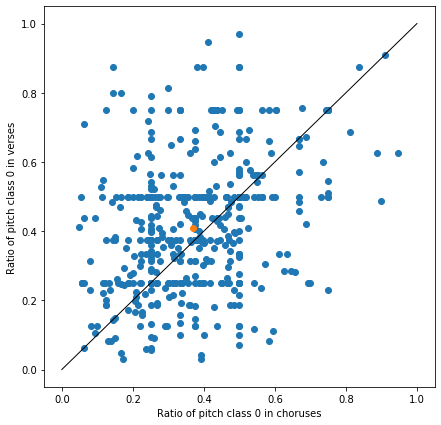

Centroid : (0.3702,0.4091)
std are 0.1635 for choruses and 0.1863 for verses
Independence t-test : t[954] = -3.4205, p-value = 0.0007


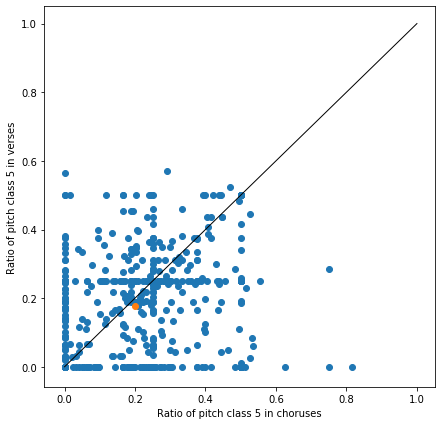

Centroid : (0.2007,0.1782)
std are 0.1627 for choruses and 0.1502 for verses
Independence t-test : t[1070] = 2.3577, p-value = 0.0186


In [153]:
pitch_class_plot(pitch_class = 0,
                 chorus_df = chorus_section_df_0_filtered,
                 verse_df = verse_section_df_0_filtered)
pitch_class_plot(pitch_class = 5,
                 chorus_df = chorus_section_df_5_filtered,
                 verse_df = verse_section_df_5_filtered)

We see that the centroid for pitch class 0 is a bit less skewed, but the centroid for pitch class 5 records almost no change. We conclude that, whereas the presence of those patterns is itself an interesting constatation, it does not explain entirely the skewing.

These results are consistent with the paths' ones, which already emphase on the importance of the tonic, dominant and subdominant in the distinction between choruses and verses.

Other graphs shows also nice little results (e.g. the ratio maj/min chords is lower in the verses, and they tend to use more bass notes), but theses constatations are not much more than pretty anecdotes, and represent tiny variations.

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5;">
    <strong>Conclusion:</strong> TO DO
</div>

# Discussion of the results